## XAI Programming Asignment I: **Shap on OPTUNA**

The goal is to run hyperparameter optimization algorithm such as optuna, collect results from it and use SHAP to try to explain the impact of different hyperparameters on the quality of the optimization process.

## **OPTUNA - Przepotężny tuńczyk**

In [2]:
import optuna
import shap
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper
from lux.lux import LUX
import graphviz
from graphviz import Source
from IPython.display import SVG, Image

In [ ]:
def save_results(results_df, filename, directory="optuna_results"):
    os.makedirs(directory, exist_ok=True)
    results_df.to_csv(f"{directory}/{filename}.csv", index=False)

In [3]:
def load_results(filename, directory="optuna_results"):
    results_df = pd.read_csv(f"{directory}/{filename}.csv")
    return results_df

### **RandomForestClassifier optimization performed on the Adult dataset**


In [ ]:
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
parameters = [
    "n_estimators",
    "max_depth",
    "min_samples_split",
    "min_samples_leaf",
    "max_features",
    "criterion",
    "class_weight"
]

In [ ]:
def objective_randomforest(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 10000)
    max_depth = trial.suggest_int("max_depth", 5, 1000)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 1000)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 500)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        class_weight=class_weight
    )

    score = cross_val_score(model, X_train, y_train, cv=3, scoring="f1", n_jobs=-1).mean()
    return score

The dataset is imbalanced so we maximize F1-score.

In [ ]:
study = optuna.create_study(direction="maximize")

[I 2025-01-08 21:06:45,899] A new study created in memory with name: no-name-e528cece-3759-40cf-81a7-b4d6259ea797


In [ ]:
study.optimize(objective_randomforest, n_trials=500, n_jobs=-1)

[I 2025-01-08 21:07:04,005] Trial 5 finished with value: 0.5758423396556499 and parameters: {'n_estimators': 1898, 'max_depth': 364, 'min_samples_split': 998, 'min_samples_leaf': 319, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None}. Best is trial 5 with value: 0.5758423396556499.
[I 2025-01-08 21:07:13,693] Trial 4 finished with value: 0.6214062299945151 and parameters: {'n_estimators': 3713, 'max_depth': 873, 'min_samples_split': 659, 'min_samples_leaf': 451, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.6214062299945151.
[I 2025-01-08 21:07:15,562] Trial 7 finished with value: 0.6297341011273048 and parameters: {'n_estimators': 3239, 'max_depth': 942, 'min_samples_split': 249, 'min_samples_leaf': 98, 'max_features': 'log2', 'criterion': 'entropy', 'class_weight': None}. Best is trial 7 with value: 0.6297341011273048.
[I 2025-01-08 21:07:24,049] Trial 18 finished with value: 0.5941002496537355 and parameters:

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best f1_score:", study.best_value)

Best hyperparameters: {'n_estimators': 5016, 'max_depth': 641, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced'}
Best f1_score: 0.7066157257483057


In [ ]:
results_df = study.trials_dataframe()

In [ ]:
save_results(results_df, 'random_forest_adult')

In [ ]:
best_params_df = pd.DataFrame([study.best_params])

In [ ]:
save_results(best_params_df, filename='random_forest_adult_best_params', directory="optuna_results")

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
for param in parameters:
    fig = optuna.visualization.plot_slice(study, params=[param])
    fig.update_layout(
        title=f"Slice Plot for {param}",
        yaxis_title="Objective Value",
        xaxis_title=param
    )

    pio.show(fig)

In [183]:
results_df = load_results('random_forest_adult')

In [184]:
X_shap = results_df[[
    "params_n_estimators",
    "params_max_depth",
    "params_min_samples_split",
    "params_min_samples_leaf",
    "params_max_features",
    "params_criterion",
    "params_class_weight"
]]

y_shap = results_df["value"]

categorical_columns = ["params_max_features", "params_criterion", "params_class_weight"]

In [185]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(X_shap[categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X_shap.index)

X_shap_encoded = pd.concat(
    [X_shap.drop(columns=categorical_columns), encoded_features_df],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(X_shap_encoded, y_shap, test_size=0.2)

In [186]:
best_params_df = load_results('random_forest_adult_best_params', directory='optuna_results')
best_params_df.columns = ['params_' + col for col in best_params_df.columns]

In [187]:
best_params_index = X_shap[
    (X_shap["params_n_estimators"] == best_params_df["params_n_estimators"].values[0]) &
    (X_shap["params_max_depth"] == best_params_df["params_max_depth"].values[0]) &
    (X_shap["params_max_features"] == best_params_df["params_max_features"].values[0]) &
    (X_shap["params_min_samples_leaf"] == best_params_df["params_min_samples_leaf"].values[0]) &
    (X_shap["params_min_samples_split"] == best_params_df["params_min_samples_split"].values[0]) &
    (X_shap["params_criterion"] == best_params_df["params_criterion"].values[0]) &
    (X_shap["params_class_weight"] == best_params_df["params_class_weight"].values[0])
].index[0]

In [188]:
best_params_record_encoded = X_shap_encoded.loc[best_params_index]

#### **Decision Tree -  RandomForestClassifier optimization on Adult dataset**

In [ ]:
def objective_random_forest_adult_decision_tree(trial):
    max_depth = trial.suggest_int("max_depth", 2, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 5, 30)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 30)

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_decision_tree, n_trials=200, n_jobs=14)

[I 2025-01-16 20:29:26,243] A new study created in memory with name: no-name-2cf0ca95-f33d-4459-8f4e-5dba5ee32d81
[I 2025-01-16 20:29:26,287] Trial 0 finished with value: 0.01225117550201856 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 26, 'max_features': 'log2', 'max_leaf_nodes': 28}. Best is trial 0 with value: 0.01225117550201856.
[I 2025-01-16 20:29:26,289] Trial 1 finished with value: 0.013851183406737968 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_leaf_nodes': 28}. Best is trial 0 with value: 0.01225117550201856.
[I 2025-01-16 20:29:26,302] Trial 2 finished with value: 0.010261927797047524 and parameters: {'max_depth': 5, 'min_samples_split': 38, 'min_samples_leaf': 29, 'max_features': 'log2', 'max_leaf_nodes': 19}. Best is trial 2 with value: 0.010261927797047524.
[I 2025-01-16 20:29:26,303] Trial 3 finished with value: 0.010384385488672503 and parameters: {'max_depth': 7, 'min_sam

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.007124084985569118
Params: {'max_depth': 7, 'min_samples_split': 26, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_leaf_nodes': 19}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='decision_tree_best_params', directory='random_forest_adult_models')

In [ ]:
best_params_df = load_results(filename='decision_tree_best_params', directory='random_forest_adult_models')

In [ ]:
model = DecisionTreeRegressor(
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0],
    max_leaf_nodes=int(best_params_df['max_leaf_nodes'].iloc[0])
)

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, max_features='log2', max_leaf_nodes=19,
                      min_samples_leaf=5, min_samples_split=26)

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.007179027974640263


In [ ]:
instance = best_params_record_encoded.to_frame().T

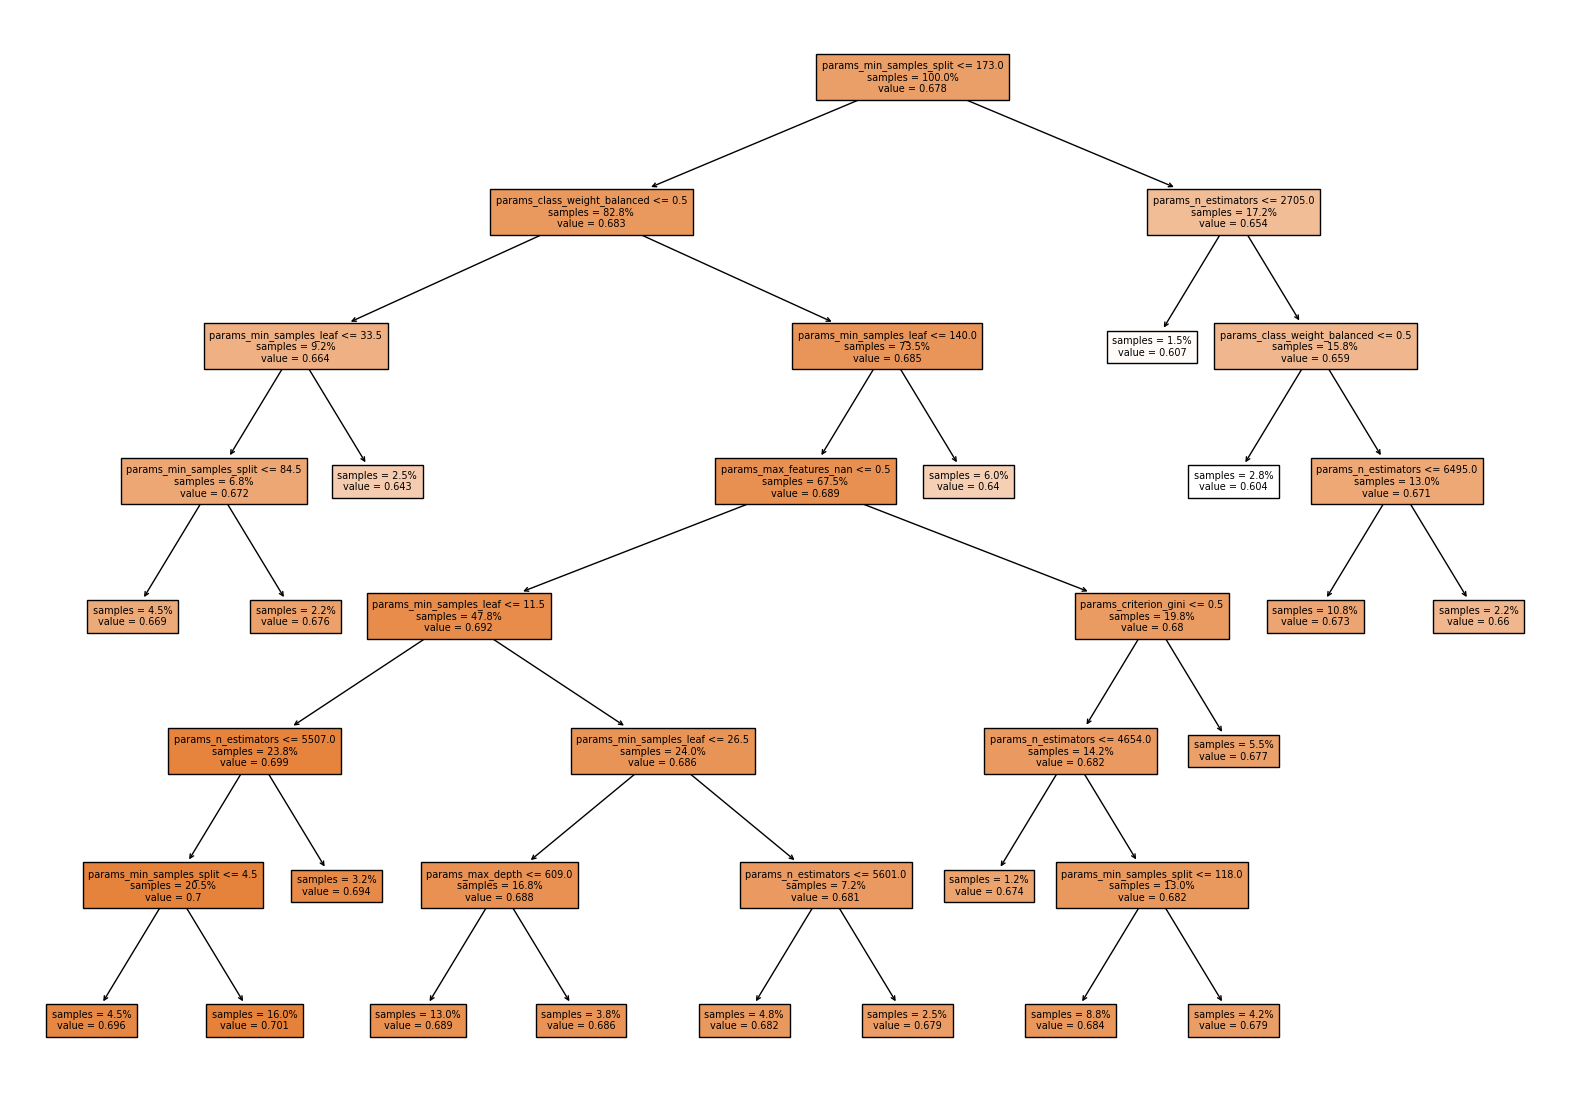

In [ ]:
plt.figure(figsize=(20, 14))

plot_tree(
    model,
    feature_names=X_train.columns,
    filled=True,
    impurity=False,
    proportion=True,
    fontsize=7
)

plt.show()

In [ ]:
feature_names = X_train.columns
tree = model.tree_
feature = tree.feature
threshold = tree.threshold
node_indicator = model.decision_path(instance)
n_node_samples = tree.n_node_samples
value = tree.value
leaf_id = model.apply(instance)

print("Decision path:")
for node_index in node_indicator.indices:
    if node_index == leaf_id:
        total_samples = n_node_samples[0]
        leaf_samples = n_node_samples[node_index]
        percentage_samples = (leaf_samples / total_samples) * 100
        val = value[node_index][0][0]
        print(f'Leaf id: {node_index}')
        print(f"Samples = {percentage_samples:.2f}%")
        print(f"Value = {val:.3f}")
    else:
        feature_name = feature_names[feature[node_index]]
        threshold_value = threshold[node_index]
        feature_value = instance.iloc[0, feature[node_index]]
        if feature_value <= threshold_value: condition = "TRUE"
        else: condition = "FALSE"
        print(f"Node {node_index}: {feature_name} <= {threshold_value}  {condition}")

Decision path:
Node 0: params_min_samples_split <= 173.0  TRUE
Node 1: params_class_weight_balanced <= 0.5  FALSE
Node 8: params_min_samples_leaf <= 140.0  TRUE
Node 9: params_max_features_nan <= 0.5  TRUE
Node 11: params_min_samples_leaf <= 11.5  TRUE
Node 13: params_n_estimators <= 5507.0  TRUE
Node 21: params_min_samples_split <= 4.5  FALSE
Leaf id: 24
Samples = 16.00%
Value = 0.701


#### **Shap values - RandomForestClassifier optimization on Adult dataset**
To compare results and improve reliability of SHAP explanations, we take 3 models to approximate hyperparameter impact.
* RandomForestRegressor
* XGBoostRegressor
* MLPRegressor

Models are trained on the output from optimization process on Adult dataset. They are tuned with Optuna as well.

##### RandomForestRegressor

In [ ]:
def objective_random_forest_adult_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 100)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1
    ).mean()

    return score

It's a regression problem - we minimize Mean Absolute Error (MAE).

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_random_forest, n_trials=200, n_jobs=-1)

[I 2025-01-09 13:38:38,954] A new study created in memory with name: no-name-ff1fb974-7127-4a97-b161-e623868f3c13
[I 2025-01-09 13:38:40,492] Trial 0 finished with value: 0.006600336997398387 and parameters: {'n_estimators': 358, 'max_depth': 84, 'max_features': 0.6821941871300614, 'min_samples_leaf': 17, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 0 with value: 0.006600336997398387.
[I 2025-01-09 13:38:40,613] Trial 1 finished with value: 0.006695949886778431 and parameters: {'n_estimators': 333, 'max_depth': 31, 'max_features': 0.5260162226461135, 'min_samples_leaf': 11, 'min_samples_split': 13, 'bootstrap': True}. Best is trial 0 with value: 0.006600336997398387.
[I 2025-01-09 13:38:40,658] Trial 2 finished with value: 0.00654465942903219 and parameters: {'n_estimators': 424, 'max_depth': 76, 'max_features': 0.9968031766796723, 'min_samples_leaf': 12, 'min_samples_split': 16, 'bootstrap': True}. Best is trial 2 with value: 0.00654465942903219.
[I 2025-01-09 13:38:40,8

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.0020171756185724792
Params: {'n_estimators': 534, 'max_depth': 52, 'max_features': 0.859106244552438, 'min_samples_leaf': 1, 'min_samples_split': 4, 'bootstrap': False}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='random_forest_best_params', directory='random_forest_adult_models')

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='random_forest_adult_models')

In [ ]:
model = RandomForestRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=52,
                      max_features=0.859106244552438, min_samples_split=4,
                      n_estimators=534)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

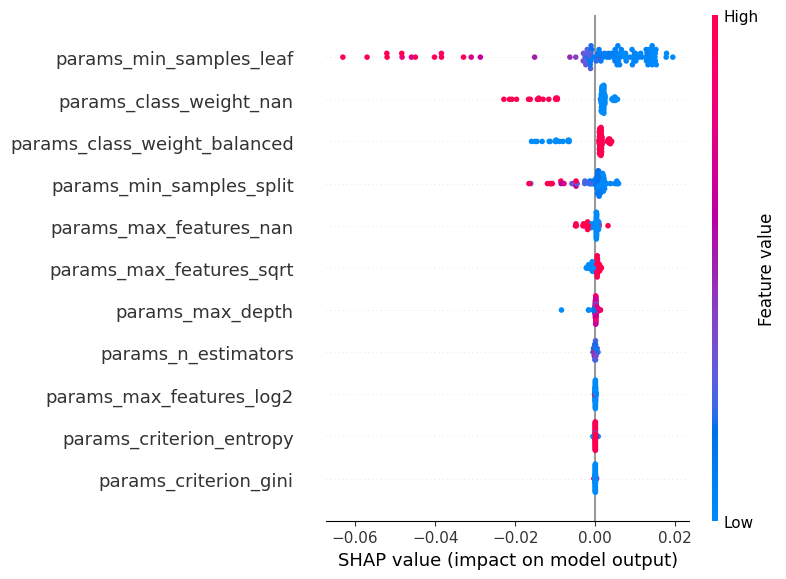

In [ ]:
shap.summary_plot(shap_values, X_test)

Optuna focuses on values that provide the best model performance so most instances have SHAP values greater than or equal to 0.

Better performance can be achieved when:
* *min_samples_leaf* has lower values
* *class_weight* value equals 'balanced'
* *min_samples_split* has lower values
* *max_features* equals 'sqrt'

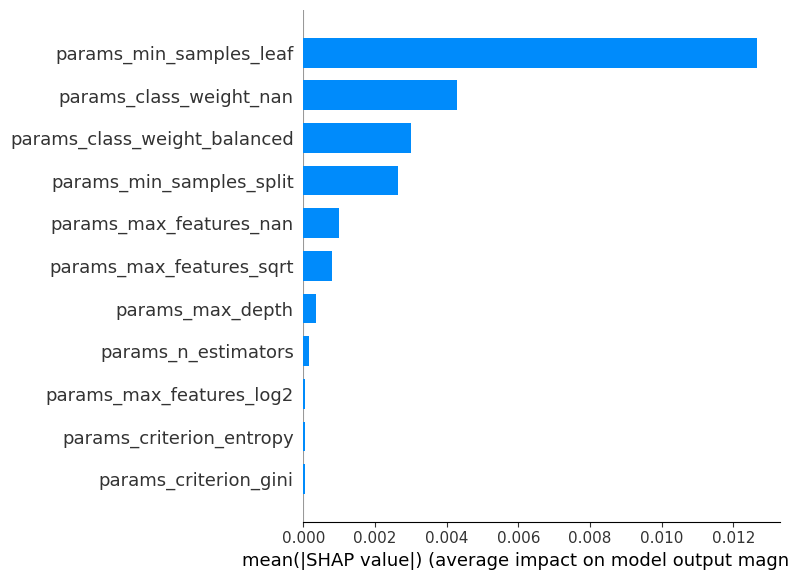

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* min_samples_leaf
* class_weight
* min_samples_split

Least important features:
* criterion
* max_features = 'log2'
* n_estimators

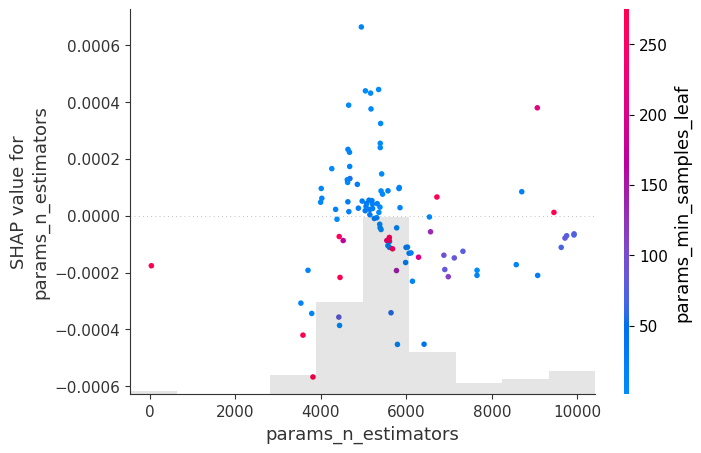

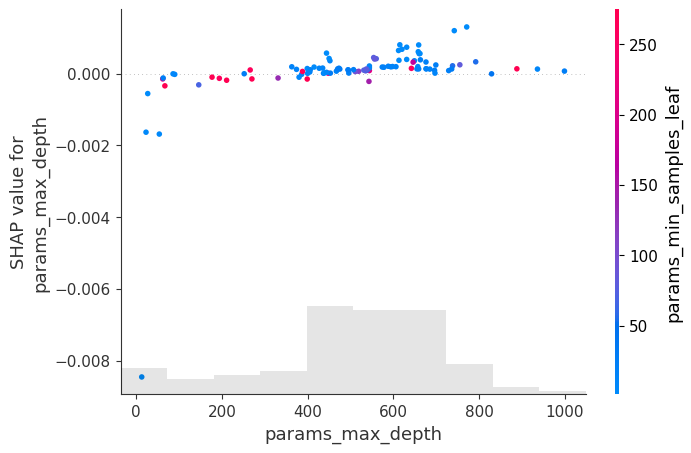

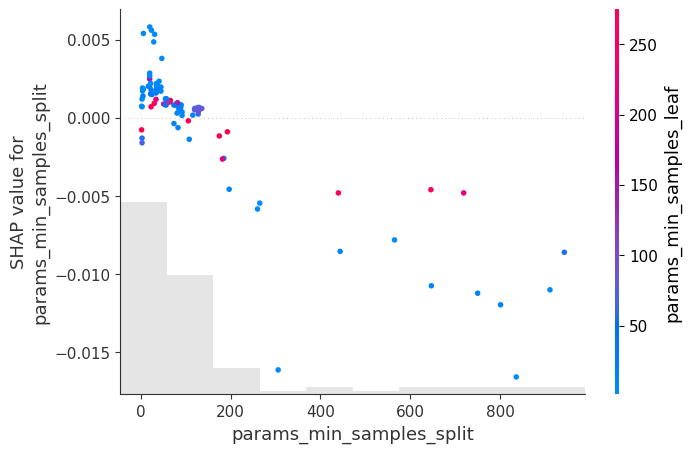

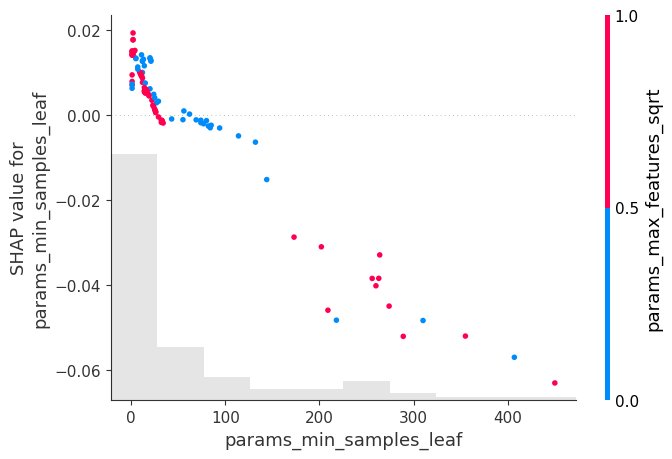

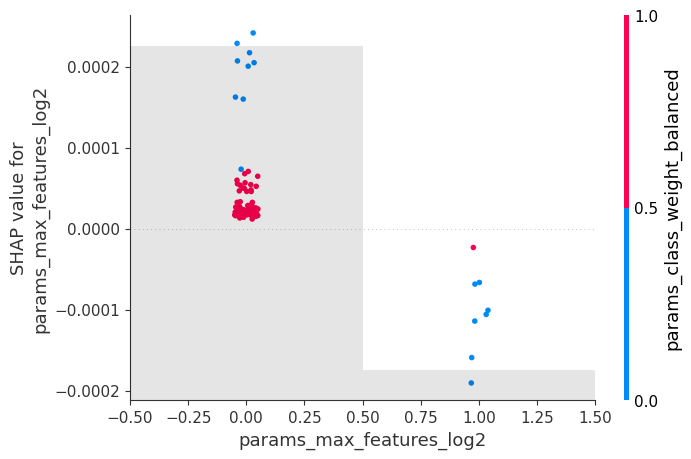

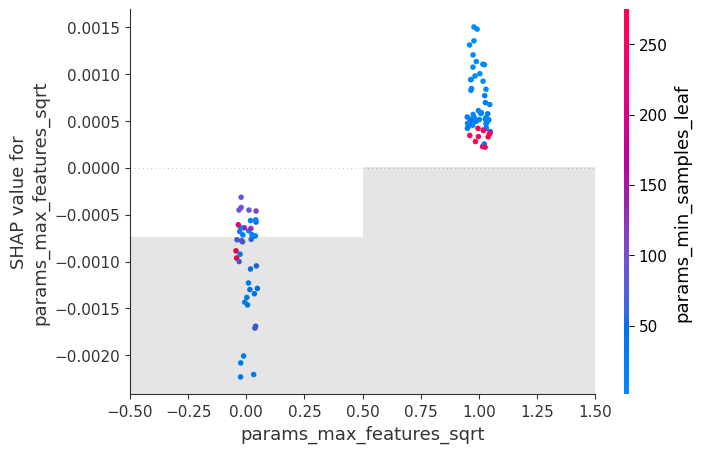

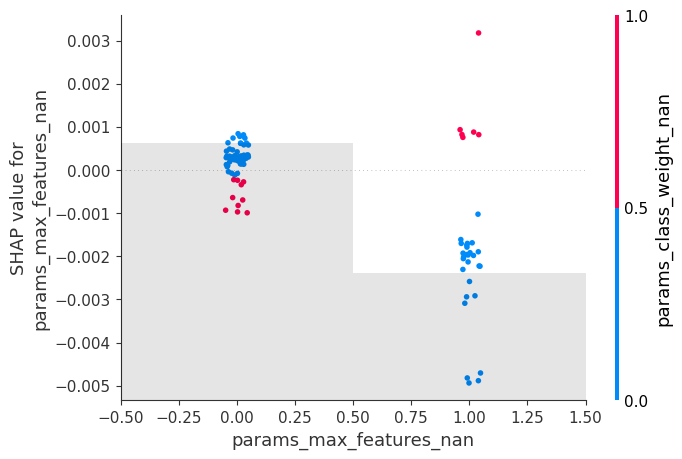

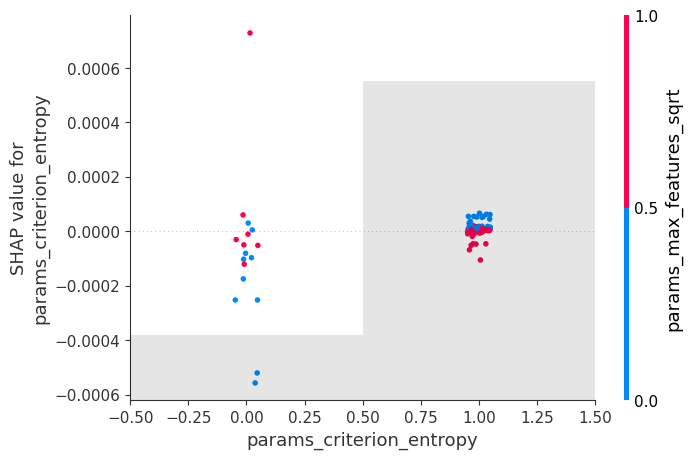

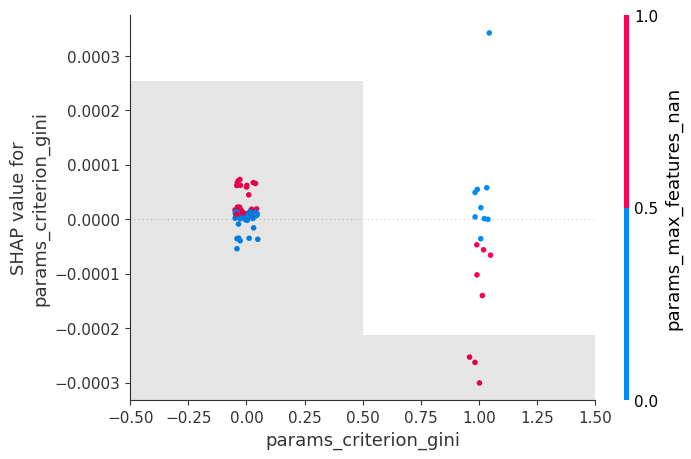

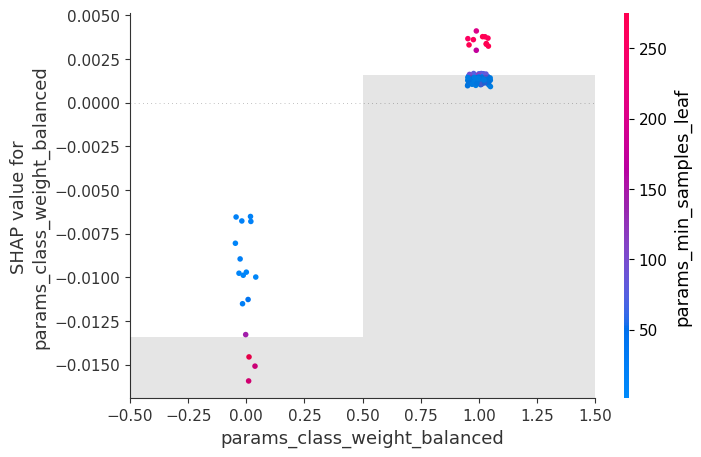

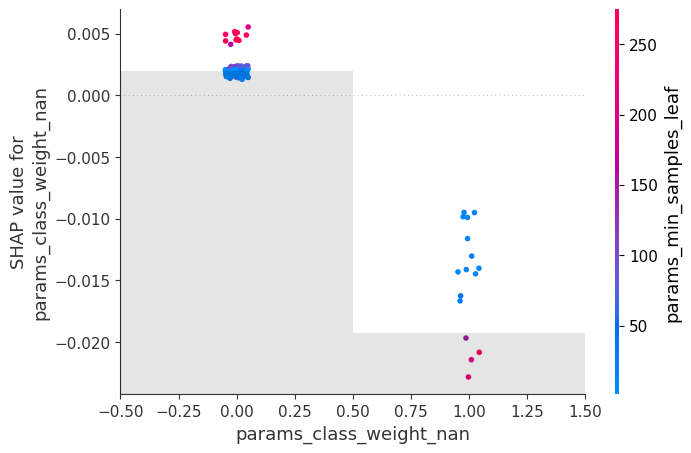

In [ ]:
feature_names = list(X_test.columns)

for i, column in enumerate(X_test.columns):
    shap.plots.scatter(shap_values[:, feature_names.index(column)], color=shap_values)


Analyzing the charts we can see that most instances have hyperparameters with values (in range):
* n_estimators: 4000 - 5000
* max_depth: 400 - 700
* min_samples_split: 0 - 200
* min_samples_leaf: 0 - 50
* criterion = 'entropy'
* class_weight = 'balanced'

The less instances have:
* max_features = 'log2'

In [ ]:
shap_values_for_best_record = explainer(best_params_record_encoded.to_frame().T)

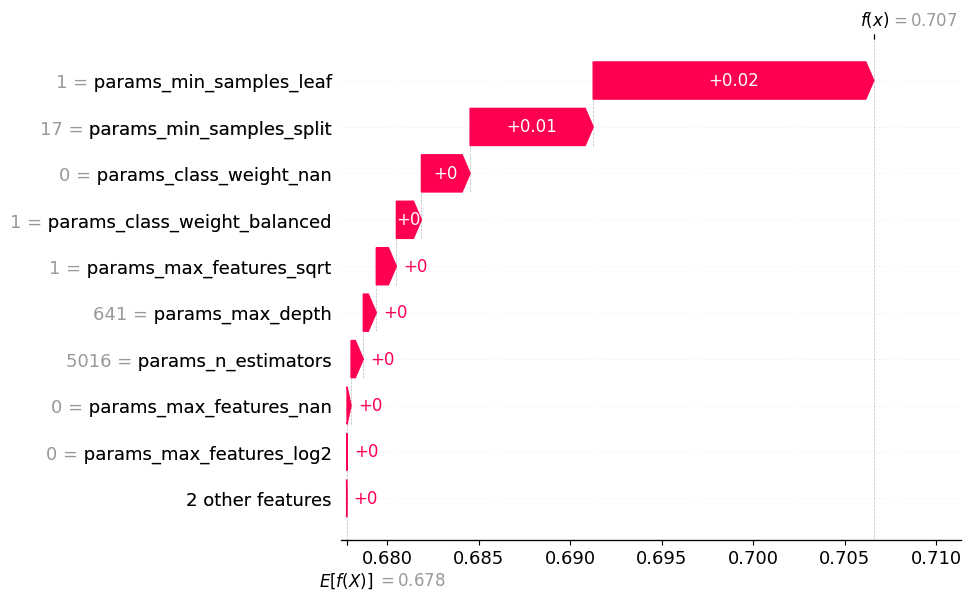

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the highest F1-score, the greatest positive impact on the result (compared to the average) have:
* min_samples_leaf
* min_samples_split
* class_weight

The rest of the parameters have a slight influence on the score.

##### XGBRegressor

In [ ]:
def objective_random_forest_adult_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        n_estimators=n_estimators,
        subsample=subsample,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=10
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=10
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_xgb, n_trials=200, n_jobs=10)

[I 2025-01-09 17:19:41,204] A new study created in memory with name: no-name-7397ce16-d772-4a9b-8757-4f7a1c5cc947
[I 2025-01-09 17:19:42,334] Trial 1 finished with value: 0.016672790377141786 and parameters: {'learning_rate': 0.0729112033940553, 'max_depth': 86, 'min_child_weight': 5, 'gamma': 2, 'n_estimators': 76, 'subsample': 0.7439640098714244}. Best is trial 1 with value: 0.016672790377141786.
[I 2025-01-09 17:19:43,841] Trial 2 finished with value: 0.016717220965406784 and parameters: {'learning_rate': 0.054352110856045605, 'max_depth': 53, 'min_child_weight': 1, 'gamma': 10, 'n_estimators': 72, 'subsample': 0.6724016550767009}. Best is trial 1 with value: 0.016672790377141786.
[I 2025-01-09 17:19:47,379] Trial 0 finished with value: 0.0021761420691965654 and parameters: {'learning_rate': 0.095306437484261, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0, 'n_estimators': 393, 'subsample': 0.5404220252292199}. Best is trial 0 with value: 0.0021761420691965654.
[I 2025-01-09 17:1

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.0017575396978065626
Params: {'learning_rate': 0.14118738007830714, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'n_estimators': 698, 'subsample': 0.7967266258810052}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='xgb_best_params', directory='random_forest_adult_models')

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='random_forest_adult_models')

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1411873800783071,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=698, n_jobs=10,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

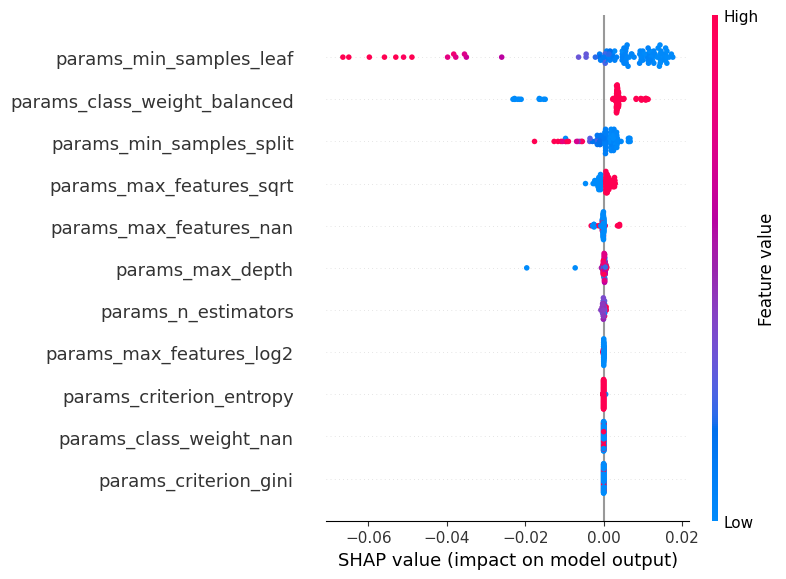

In [ ]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *min_samples_leaf* has lower values
* *class_weight* equals 'balanced'
* *min_samples_split* has lower values
* *max_features* value equals 'sqrt'

Again, most instances instances have SHAP values greater than or equal to 0.


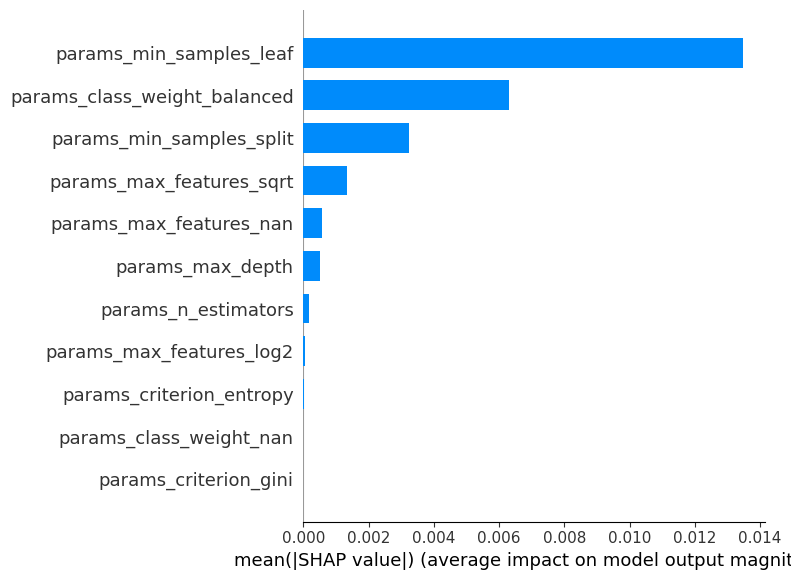

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* min_samples_leaf
* class_weight = 'balanced'
* min_samples_split

Least important features:
* criterion
* class weight = None
* max_features = 'log2'
* n_estimators

In [ ]:
shap_values_for_best_record = explainer(best_params_record_encoded.to_frame().T)

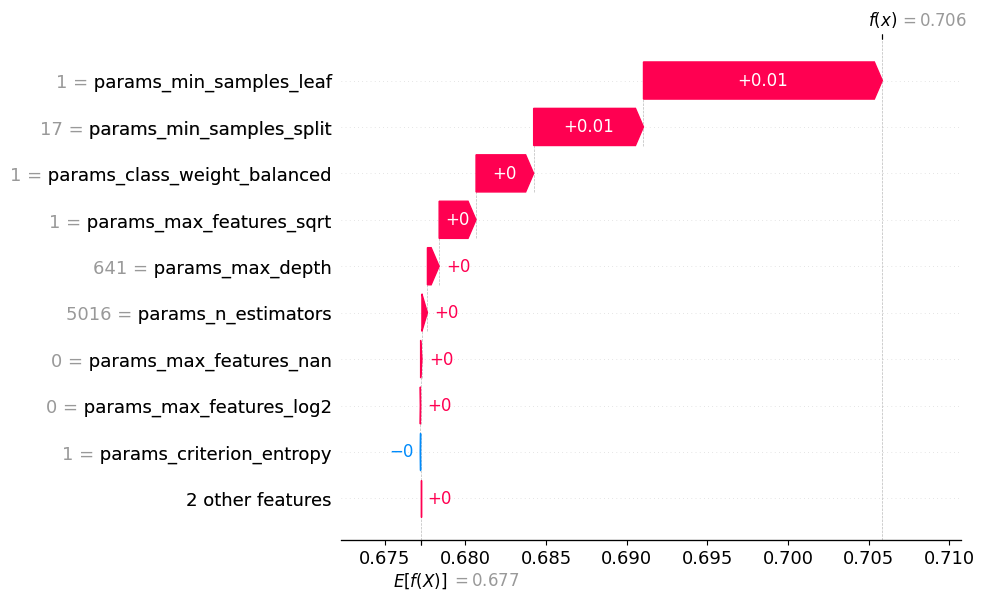

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the highest F1-score, the greatest positive impact on the result (compared to the average) have:
* min_samples_leaf
* min_samples_split
* class_weight

The rest of the parameters have a slight influence on the score.

##### MLPRegressor

In [ ]:
def objective_random_forest_adult_mlp(trial):

    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(25,), (50,), (100,), (50, 25), (100, 50)]
    )
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.001)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        alpha=alpha,
        max_iter=max_iter
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=10
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest_adult_mlp, n_trials=200, n_jobs=10)

[I 2025-01-09 20:02:26,696] A new study created in memory with name: no-name-d818a090-6efa-4bab-b354-093d8a0318bd
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (25,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(mes

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.13679298752915378
Params: {'hidden_layer_sizes': (50, 25), 'solver': 'lbfgs', 'learning_rate_init': 0.00026043986741217443, 'batch_size': 64, 'alpha': 0.0006820933299027283, 'max_iter': 1915}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='mlp_best_params', directory='random_forest_adult_models')

In [ ]:
best_params_df = load_results(filename='mlp_best_params', directory='random_forest_adult_models')

In [ ]:
model = MLPRegressor(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train)

MLPRegressor(alpha=0.0006820933299027, batch_size=64,
             hidden_layer_sizes=(50, 25), learning_rate_init=0.0002604398674121,
             max_iter=1915, solver='lbfgs')

In [ ]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

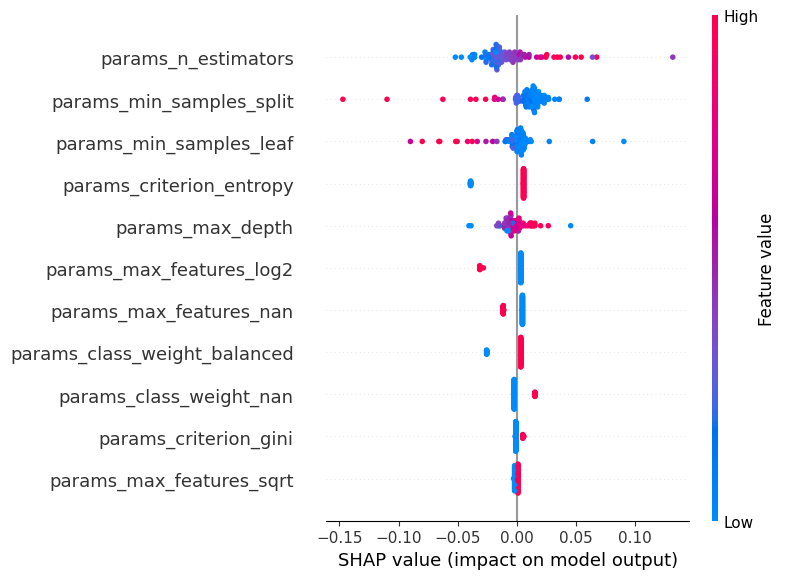

In [ ]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *n_estimators* has higher values
* *max_features* value equals 'sqrt'
* *criterion* equals 'gini' or 'entropy', Optuna chose 'entropy' more frequently
* *min_samples_leaf* has lower values
* *min_samples_split* has lower values
* *max_depth* has higher values

Negative impact on the model output have:
* low values of *n_estimators*
* low values of *min_samples_split*
* class_weight = 'None'

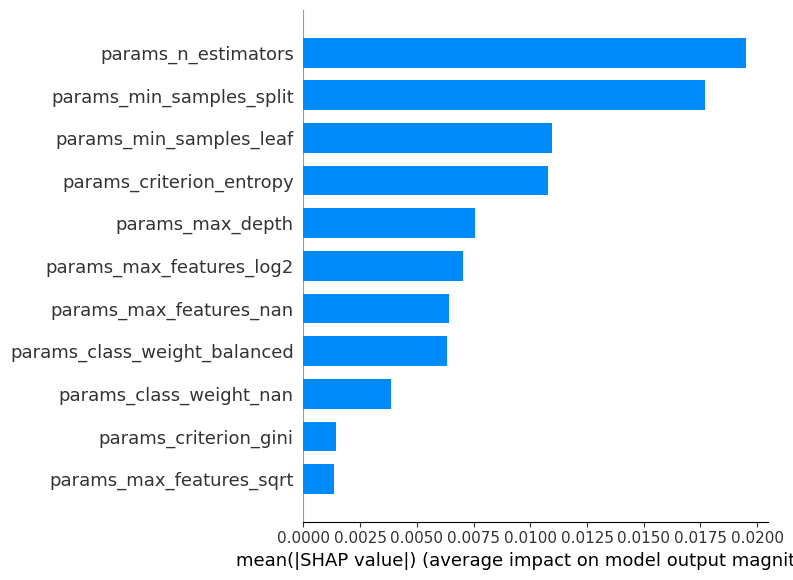

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* n_estimators
* min_samples_split
* min_samples_leaf
* criterion = 'entropy'

Least important features:
* max_features = 'sqrt'
* criterion = 'gini'
* class_weight

In [ ]:
shap_values_for_best_record = explainer(best_params_record_encoded.to_frame().T)

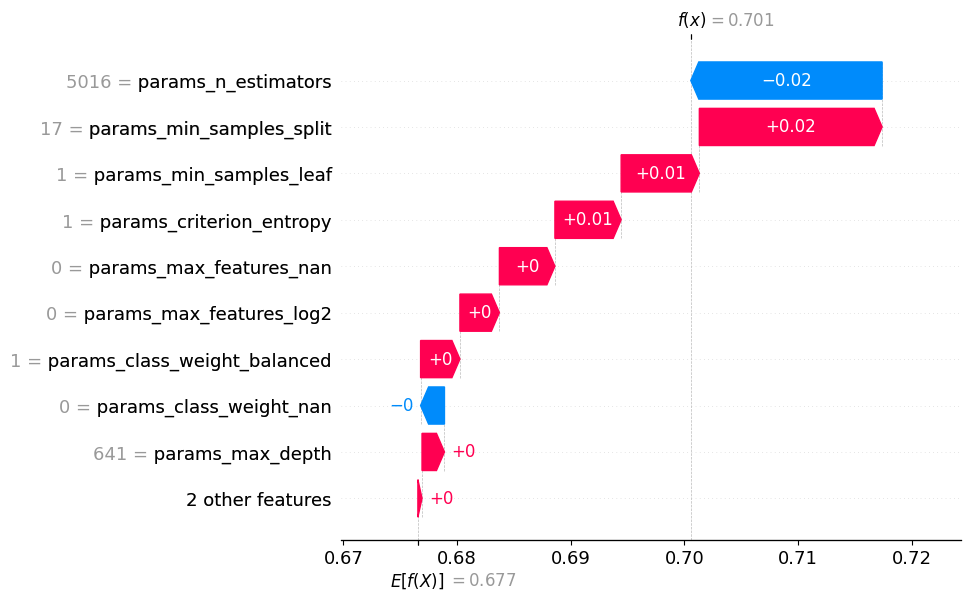

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the highest F1-score and comparing it to the average result, value of the hyperparameter *n_estimators* has negative impact on the result and the most positive have:
* min_samples_leaf
* min_samples_split
* criterion

The rest of the parameters have a slight influence on the score.

##### **Summary**

Comparing shapley values that base on RandomForest and XGBoost regressors, whose performance is much the same, we got similiar explanations and parameter importances. The most important hyperparameters are: *min_samples_leaf*, *class_weight*, *min_samples_split* and the least important is e. g. *criterion* or *n_estimators*. The results are consistent with those obtained from Optuna.

However MLPRegressor gives us a bit different results, where the *n_estimators* is the crucial one - this may be due to lower model performance. However, like other regressors, it also considers *min_samples_leaf* and *min_samples_split* in its top 3 important hyperparameters.

#### **LORE explanations - RandomForestClassifier optimization on Adult dataset**

In [12]:
y_train_intervals = pd.cut(y_train, 10)
y_train_categorical = y_train_intervals.map(str)

In [13]:
le = LabelEncoder()
le.fit(y_train_categorical)
y_train_categorical_encoded = le.transform(y_train_categorical)

In [14]:
intervals_labels = pd.DataFrame(columns=le.classes_, data=[np.arange(len(le.classes_))], index=[0])
intervals_labels

(0.57, 0.584]  (0.584, 0.598]  (0.598, 0.611]  (0.611, 0.625]  \
0              0               1               2               3   

   (0.625, 0.638]  (0.638, 0.652]  (0.652, 0.666]  (0.666, 0.679]  \
0               4               5               6               7   

   (0.679, 0.693]  (0.693, 0.707]  
0               8               9

##### RandomForestClassifier

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='random_forest_adult_models')

In [ ]:
model = RandomForestClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train_categorical_encoded)

RandomForestClassifier(bootstrap=False, max_depth=52,
                       max_features=0.859106244552438, min_samples_split=4,
                       n_estimators=534)

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_record_encoded.values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

##### XGBClassifier

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='random_forest_adult_models')

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train_categorical_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1411873800783071,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_record_encoded.values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

##### MLPClassifier

In [ ]:
best_params_df = load_results(filename='mlp_best_params', directory='random_forest_adult_models')

In [ ]:
model = MLPClassifier(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train_categorical_encoded)

MLPClassifier(alpha=0.0006820933299027, batch_size=64,
              hidden_layer_sizes=(50, 25),
              learning_rate_init=0.0002604398674121, max_iter=1915,
              solver='lbfgs')

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':50}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_record_encoded.values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

#### **LUX explanations - RandomForestClassifier optimization on Adult dataset**

##### RandomForestClassifier

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='random_forest_adult_models')

In [ ]:
model = RandomForestClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train_categorical_encoded)

RandomForestClassifier(bootstrap=False, max_depth=52,
                       max_features=0.859106244552438, min_samples_split=4,
                       n_estimators=534)

In [ ]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.1,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_record_encoded.values.reshape(1, -1),inverse_sampling=True,
        oversampling=False, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True)

LUX(max_depth=3, min_samples=50, node_size_limit=4,
    oversampling_strategy='smote',
    predict_proba=<bound method ForestClassifier.predict_proba of RandomForestClassifier(bootstrap=False, max_depth=52,
                       max_features=0.859106244552438, min_samples_split=4,
                       n_estimators=534)>)

In [ ]:
lux.justify(best_params_record_encoded.values.reshape(1,-1))

['IF params_min_samples_leaf <11.5 THEN class = 9 # 0.8863636363636364\n']

In [ ]:
cf =lux.counterfactual(best_params_record_encoded.values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

{'params_min_samples_leaf': ['< 164.4962266196582 * params_class_weight_balanced+-63.80175637493498',
  '>=11.5']}

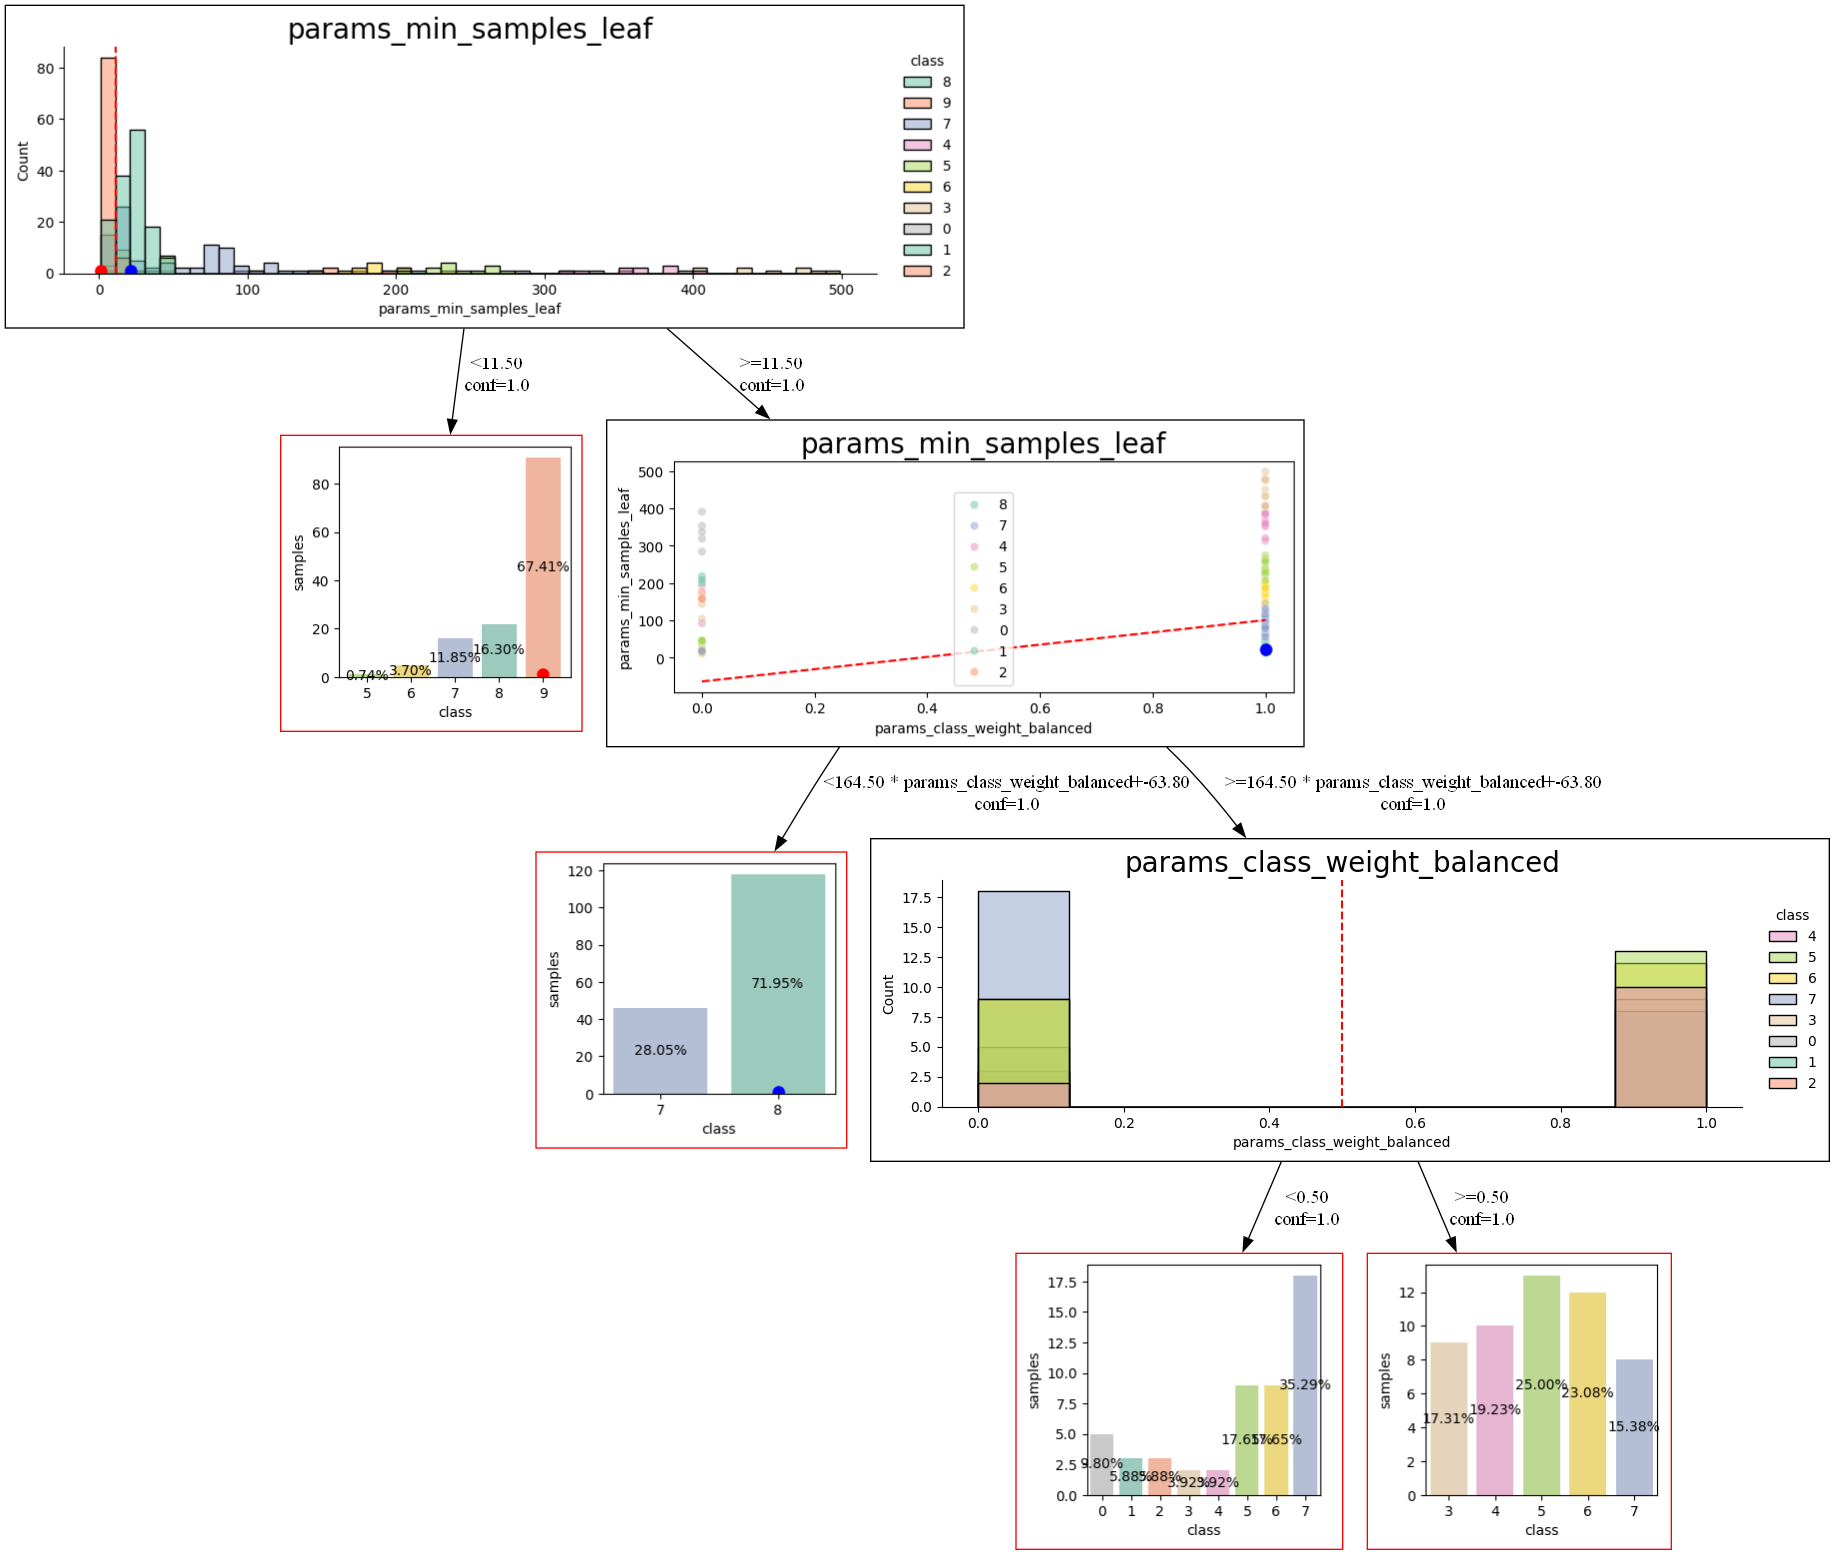

In [ ]:
i2edf = pd.DataFrame(best_params_record_encoded.values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_1.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_1.dot')
!dot -Tpng ./tree-cf-visual_1.dot > tree_1.png
Image('tree_1.png')

##### XGBClassifier

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='random_forest_adult_models')

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train_categorical_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1411873800783071,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.1,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_record_encoded.values.reshape(1, -1),inverse_sampling=True,
        oversampling=False, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True)

LUX(max_depth=3, min_samples=50, node_size_limit=4,
    oversampling_strategy='smote',
    predict_proba=<bound method XGBClassifier.predict_proba of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_ty...
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1411873800783071,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)>)

In [ ]:
lux.justify(best_params_record_encoded.values.reshape(1,-1))

['IF params_min_samples_leaf <11.5 THEN class = 9 # 0.8863636363636364\n']

In [ ]:
cf =lux.counterfactual(best_params_record_encoded.values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

{'params_min_samples_leaf': ['< 164.4982940274527 * params_class_weight_balanced+-63.803893742514',
  '>=11.5']}

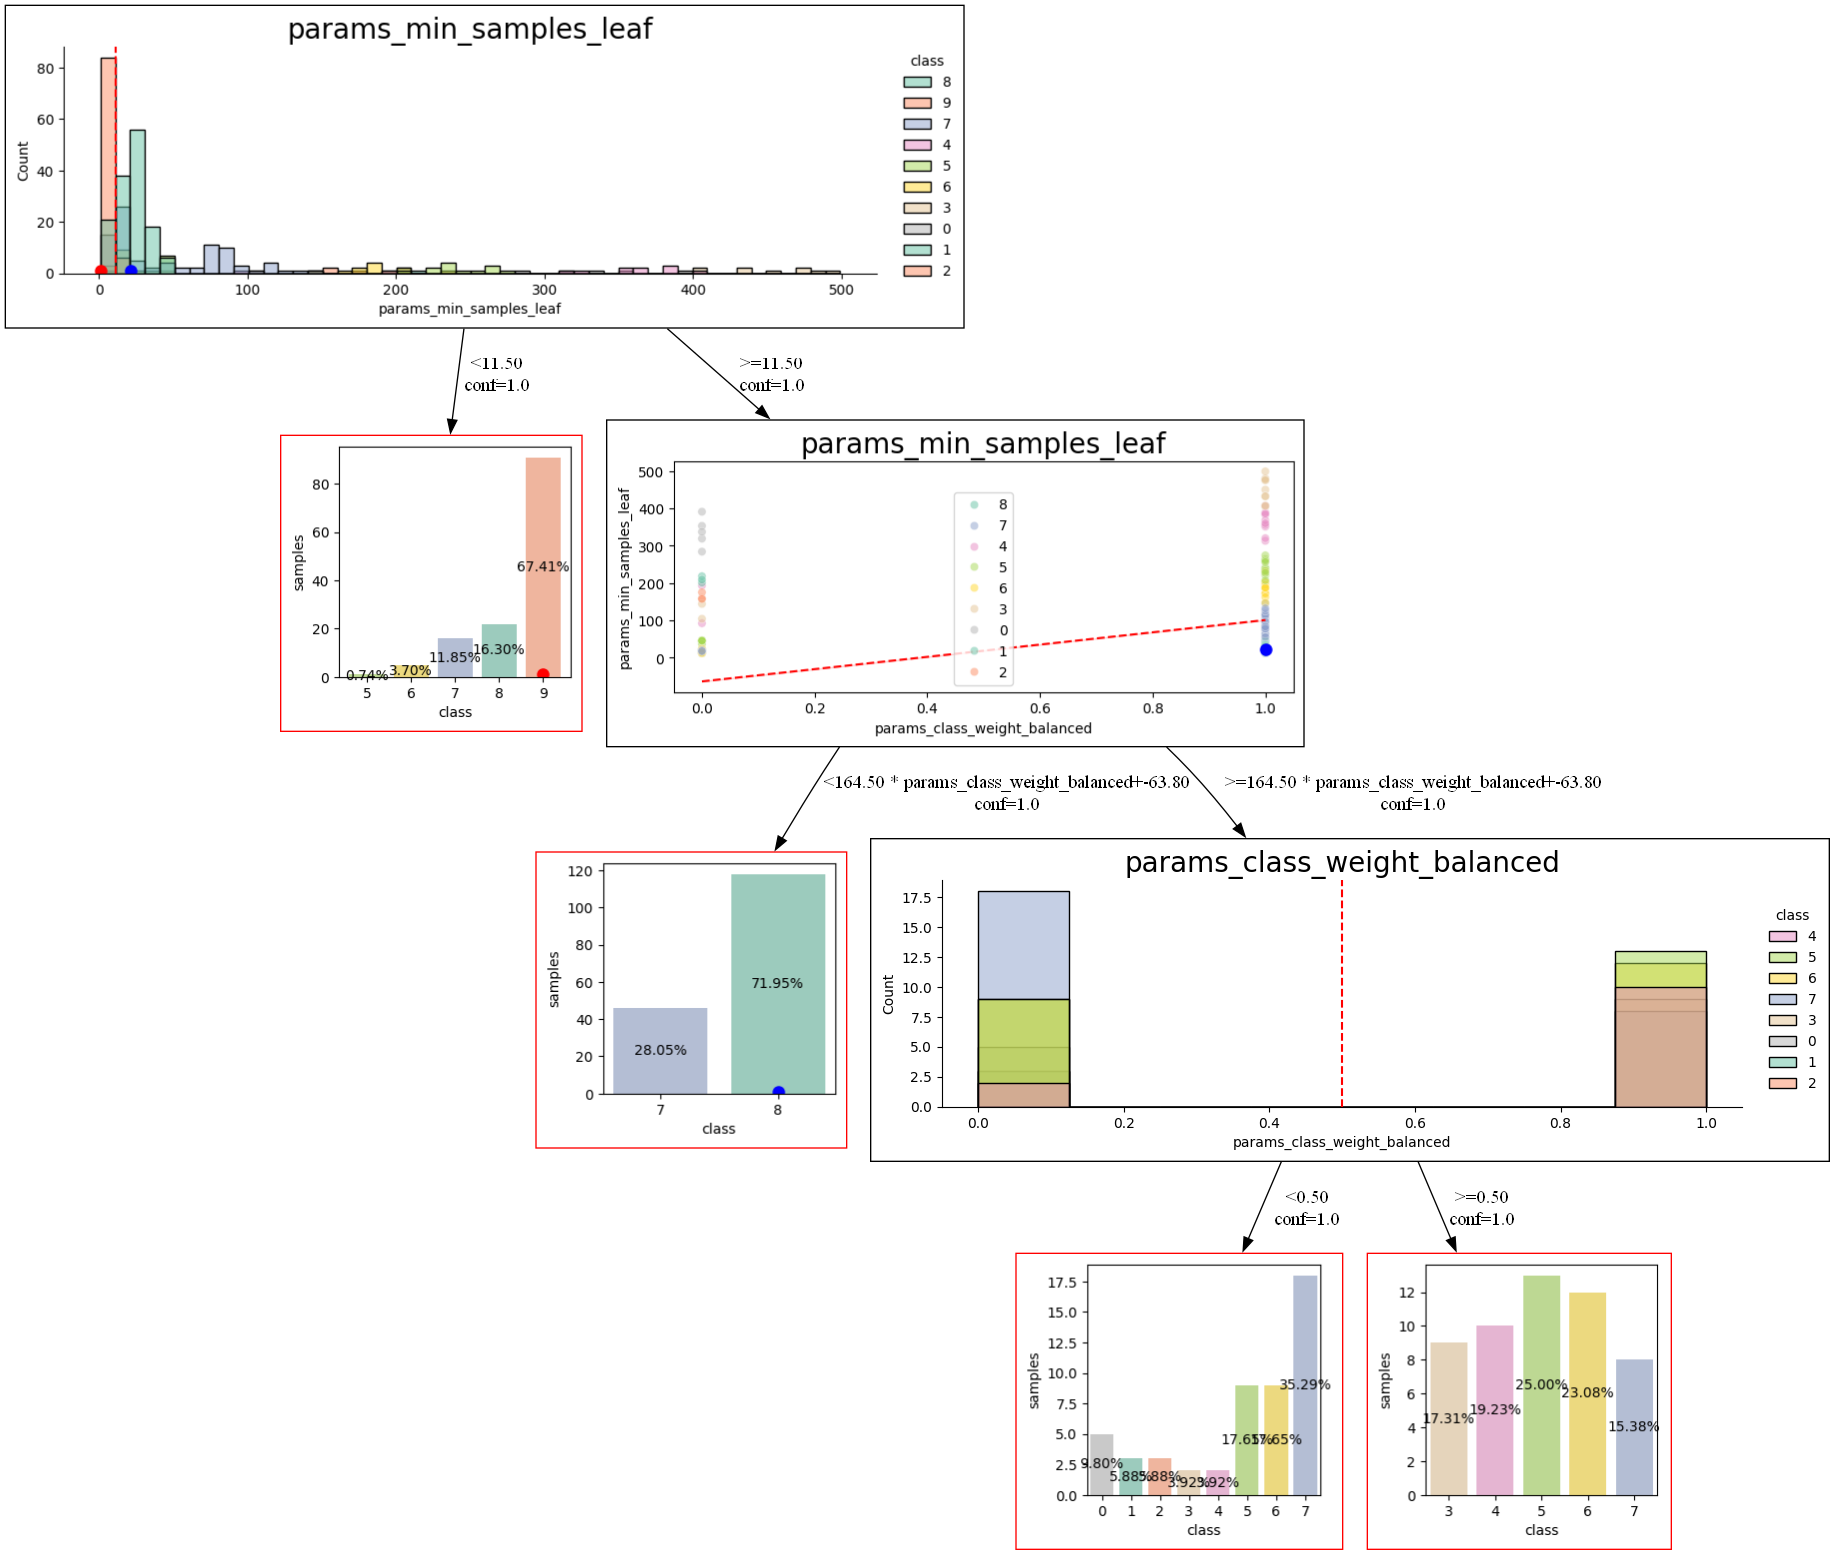

In [ ]:
i2edf = pd.DataFrame(best_params_record_encoded.values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_2.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_2.dot')
!dot -Tpng ./tree-cf-visual_2.dot > tree_2.png
Image('tree_2.png')

##### MLPClassifier

In [189]:
best_params_df = load_results(filename='mlp_best_params', directory='random_forest_adult_models')

In [190]:
model = MLPClassifier(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train_categorical_encoded)

MLPClassifier(alpha=0.0006820933299027, batch_size=64,
              hidden_layer_sizes=(50, 25),
              learning_rate_init=0.0002604398674121, max_iter=1915,
              solver='lbfgs')

In [238]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.7, max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
print(lux)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_record_encoded.values.reshape(1, -1), inverse_sampling=True, use_parity=False, parity_strategy='local',
        oversampling=False, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True
        )

LUX(max_depth=3, min_samples=50, neighborhood_size=0.7, node_size_limit=4,
    oversampling_strategy='smote',
    predict_proba=<bound method MLPClassifier.predict_proba of MLPClassifier(alpha=0.0006820933299027, batch_size=64,
              hidden_layer_sizes=(50, 25),
              learning_rate_init=0.0002604398674121, max_iter=1915,
              solver='lbfgs')>)


LUX(max_depth=3, min_samples=50, neighborhood_size=0.7, node_size_limit=4,
    oversampling_strategy='smote',
    predict_proba=<bound method MLPClassifier.predict_proba of MLPClassifier(alpha=0.0006820933299027, batch_size=64,
              hidden_layer_sizes=(50, 25),
              learning_rate_init=0.0002604398674121, max_iter=1915,
              solver='lbfgs')>)

In [239]:
lux.justify(best_params_record_encoded.values.reshape(1,-1))

['IF params_min_samples_split <427.5 THEN class = 1 # 1.0\n']

In [240]:
cf =lux.counterfactual(best_params_record_encoded.values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

{'params_min_samples_split': ['>=427.5'], 'params_max_depth': ['>=314.5']}

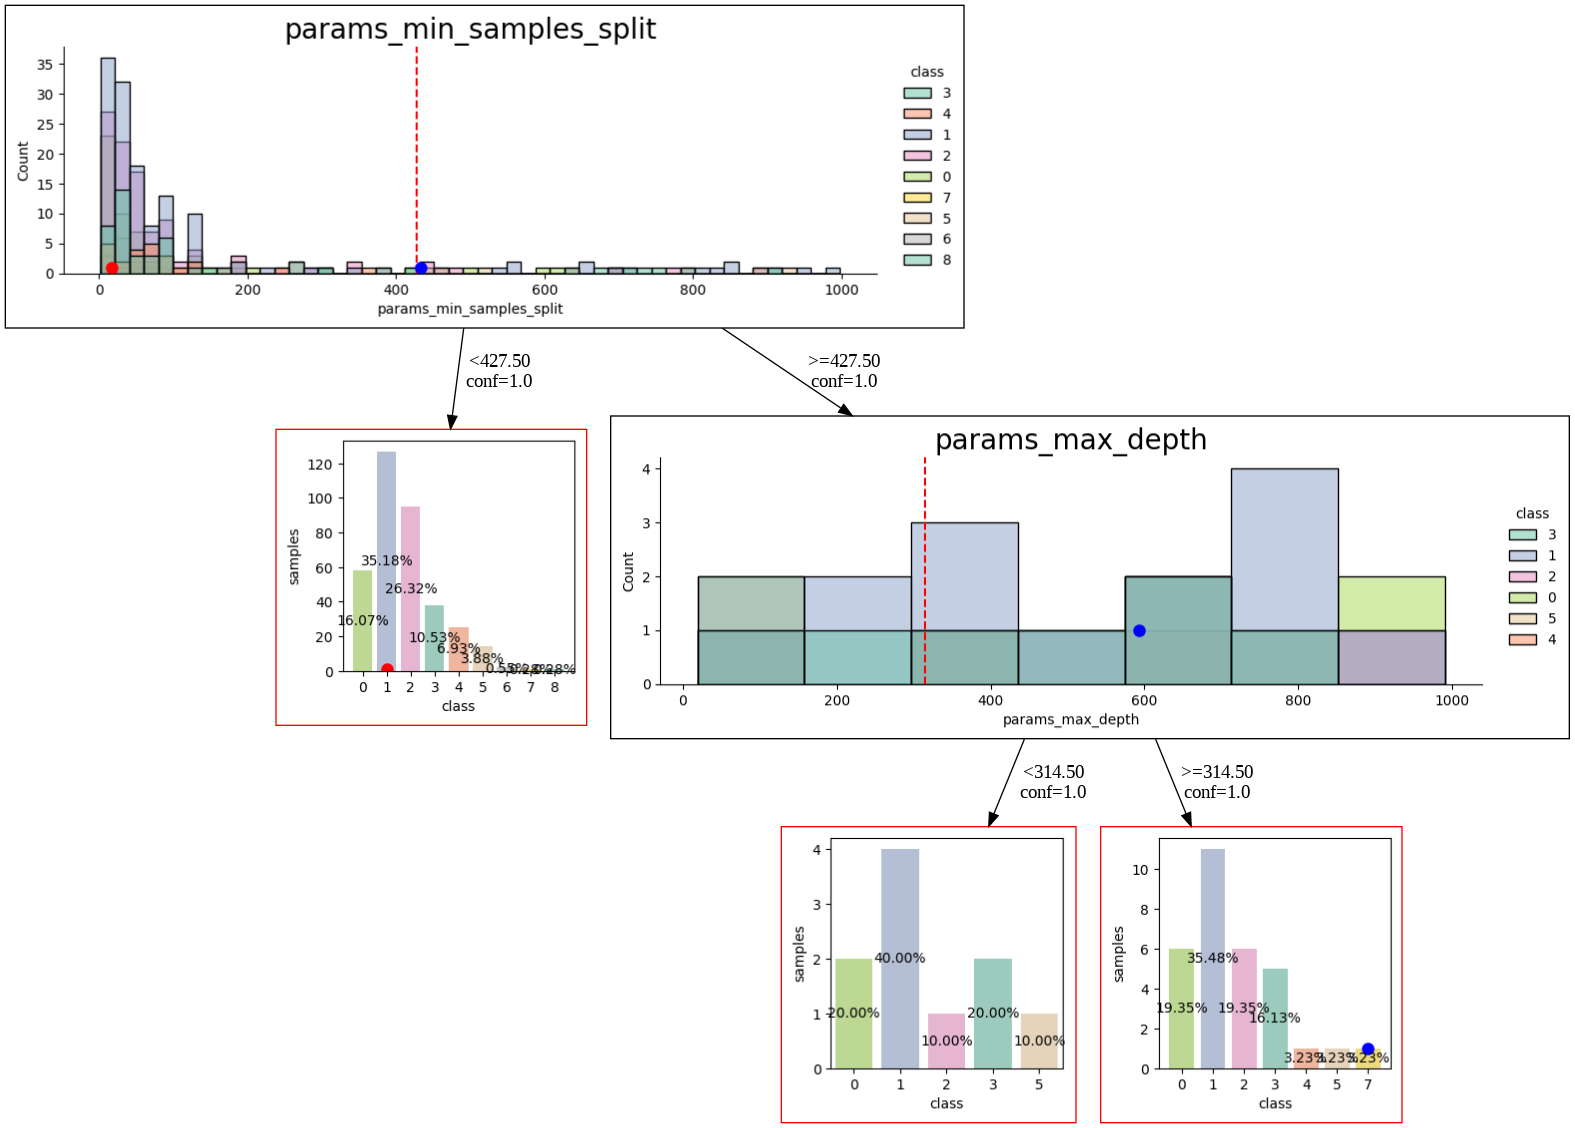

In [241]:
i2edf = pd.DataFrame(best_params_record_encoded.values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_3.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_3.dot')
!dot -Tpng ./tree-cf-visual_3.dot > tree_3.png
Image('tree_3.png')

### **XGBRegressor optimization performed on the California dataset**


In [ ]:
X, y = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
parameters = [
    "n_estimators",
    "max_depth",
    "learning_rate",
    "min_child_weight",
    "gamma",
    "subsample",
    "lambda",
    "alpha",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode"
]

In [ ]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 5000)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.4)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 100)
    gamma = trial.suggest_float("gamma", 0, 50)
    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    lambda_param = trial.suggest_float("lambda", 1, 100)
    alpha = trial.suggest_float("alpha", 0, 100)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.2, 1.0)
    colsample_bynode = trial.suggest_float("colsample_bynode", 0.2, 1.0)

    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        lambda_=lambda_param,
        alpha=alpha,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=14
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")

[I 2025-01-10 22:35:12,287] A new study created in memory with name: no-name-9c9d6fa4-5a5a-48bc-810a-f4b1b65e6aeb


In [ ]:
study.optimize(objective_xgb, n_trials=500, n_jobs=14)

[I 2025-01-10 22:35:47,740] Trial 3 finished with value: 0.4771602883979123 and parameters: {'n_estimators': 1190, 'max_depth': 69, 'learning_rate': 0.3635426189013701, 'min_child_weight': 77, 'gamma': 17.894825357395533, 'subsample': 0.7203922652045665, 'lambda': 34.25637782464009, 'alpha': 88.86284769266807, 'colsample_bytree': 0.4166676078414184, 'colsample_bylevel': 0.36927677386497965, 'colsample_bynode': 0.799321368033082}. Best is trial 3 with value: 0.4771602883979123.
[I 2025-01-10 22:36:46,449] Trial 8 finished with value: 0.4765979304042643 and parameters: {'n_estimators': 2429, 'max_depth': 98, 'learning_rate': 0.24276504310231944, 'min_child_weight': 91, 'gamma': 41.99914584537587, 'subsample': 0.7717892660138133, 'lambda': 82.59391387284397, 'alpha': 31.239682206972287, 'colsample_bytree': 0.8883861337765138, 'colsample_bylevel': 0.2265760716300097, 'colsample_bynode': 0.5364634496566203}. Best is trial 8 with value: 0.4765979304042643.
[I 2025-01-10 22:37:07,888] Trial 2

In [ ]:
print("Best hyperparameters:", study.best_params)
print(f"Value: {study.best_value}")

Best hyperparameters: {'n_estimators': 4217, 'max_depth': 89, 'learning_rate': 0.13303506238546675, 'min_child_weight': 46, 'gamma': 0.039172933097113824, 'subsample': 0.8605930456755688, 'lambda': 1.15374029356788, 'alpha': 9.887141096143289, 'colsample_bytree': 0.9726273344018967, 'colsample_bylevel': 0.9301323613912363, 'colsample_bynode': 0.3449671745393691}
Value: 0.3120045367219813


In [ ]:
results_df = study.trials_dataframe()

In [ ]:
save_results(results_df, 'xgb_california')

In [ ]:
best_params_df = pd.DataFrame([study.best_params])

In [ ]:
save_results(best_params_df, filename='xgb_california_best_params', directory="optuna_results")

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
for param in parameters:
    fig = optuna.visualization.plot_slice(study, params=[param])
    fig.update_layout(
        title=f"Slice Plot for {param}",
        yaxis_title="Objective Value",
        xaxis_title=param
    )

    pio.show(fig)

In [107]:
results_df = load_results('xgb_california')

In [108]:
X_shap = results_df[[
    "params_n_estimators",
    "params_max_depth",
    "params_learning_rate",
    "params_min_child_weight",
    "params_gamma",
    "params_subsample",
    "params_lambda",
    "params_alpha",
    "params_colsample_bytree",
    "params_colsample_bylevel",
    "params_colsample_bynode"
]]

y_shap = results_df["value"]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_shap, y_shap, test_size=0.2)

In [110]:
best_params_instance = load_results('xgb_california_best_params', directory='optuna_results')
best_params_instance.columns = ['params_' + col for col in best_params_instance.columns]

#### **Decision Tree - XGBRegressor optimization on the California dataset**

In [ ]:
def objective_xgb_california_decision_tree(trial):
    max_depth = trial.suggest_int("max_depth", 2, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 5, 30)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 30)

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_decision_tree, n_trials=200, n_jobs=14)

[I 2025-01-16 22:18:07,399] A new study created in memory with name: no-name-03703cba-12cb-4cfb-9f7e-84af344ea957
[I 2025-01-16 22:18:08,291] Trial 1 finished with value: 0.024929514696448236 and parameters: {'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'max_leaf_nodes': 14}. Best is trial 1 with value: 0.024929514696448236.
[I 2025-01-16 22:18:08,306] Trial 11 finished with value: 0.022152558930209357 and parameters: {'max_depth': 4, 'min_samples_split': 44, 'min_samples_leaf': 28, 'max_features': 'sqrt', 'max_leaf_nodes': 22}. Best is trial 11 with value: 0.022152558930209357.
[I 2025-01-16 22:18:08,307] Trial 4 finished with value: 0.026004061960377505 and parameters: {'max_depth': 3, 'min_samples_split': 50, 'min_samples_leaf': 27, 'max_features': 'sqrt', 'max_leaf_nodes': 27}. Best is trial 11 with value: 0.022152558930209357.
[I 2025-01-16 22:18:08,308] Trial 12 finished with value: 0.019632543168683358 and parameters: {'max_depth': 7, 

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.013914867145342805
Params: {'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_leaf_nodes': 20}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='decision_tree_best_params', directory='xgb_california_models')

In [ ]:
best_params_df = load_results(filename='decision_tree_best_params', directory='xgb_california_models')

In [ ]:
model = DecisionTreeRegressor(
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0],
    max_leaf_nodes=int(best_params_df['max_leaf_nodes'].iloc[0])
)

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, max_features='log2', max_leaf_nodes=20,
                      min_samples_leaf=8, min_samples_split=16)

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.01753058343335197


In [ ]:
instance = best_params_instance

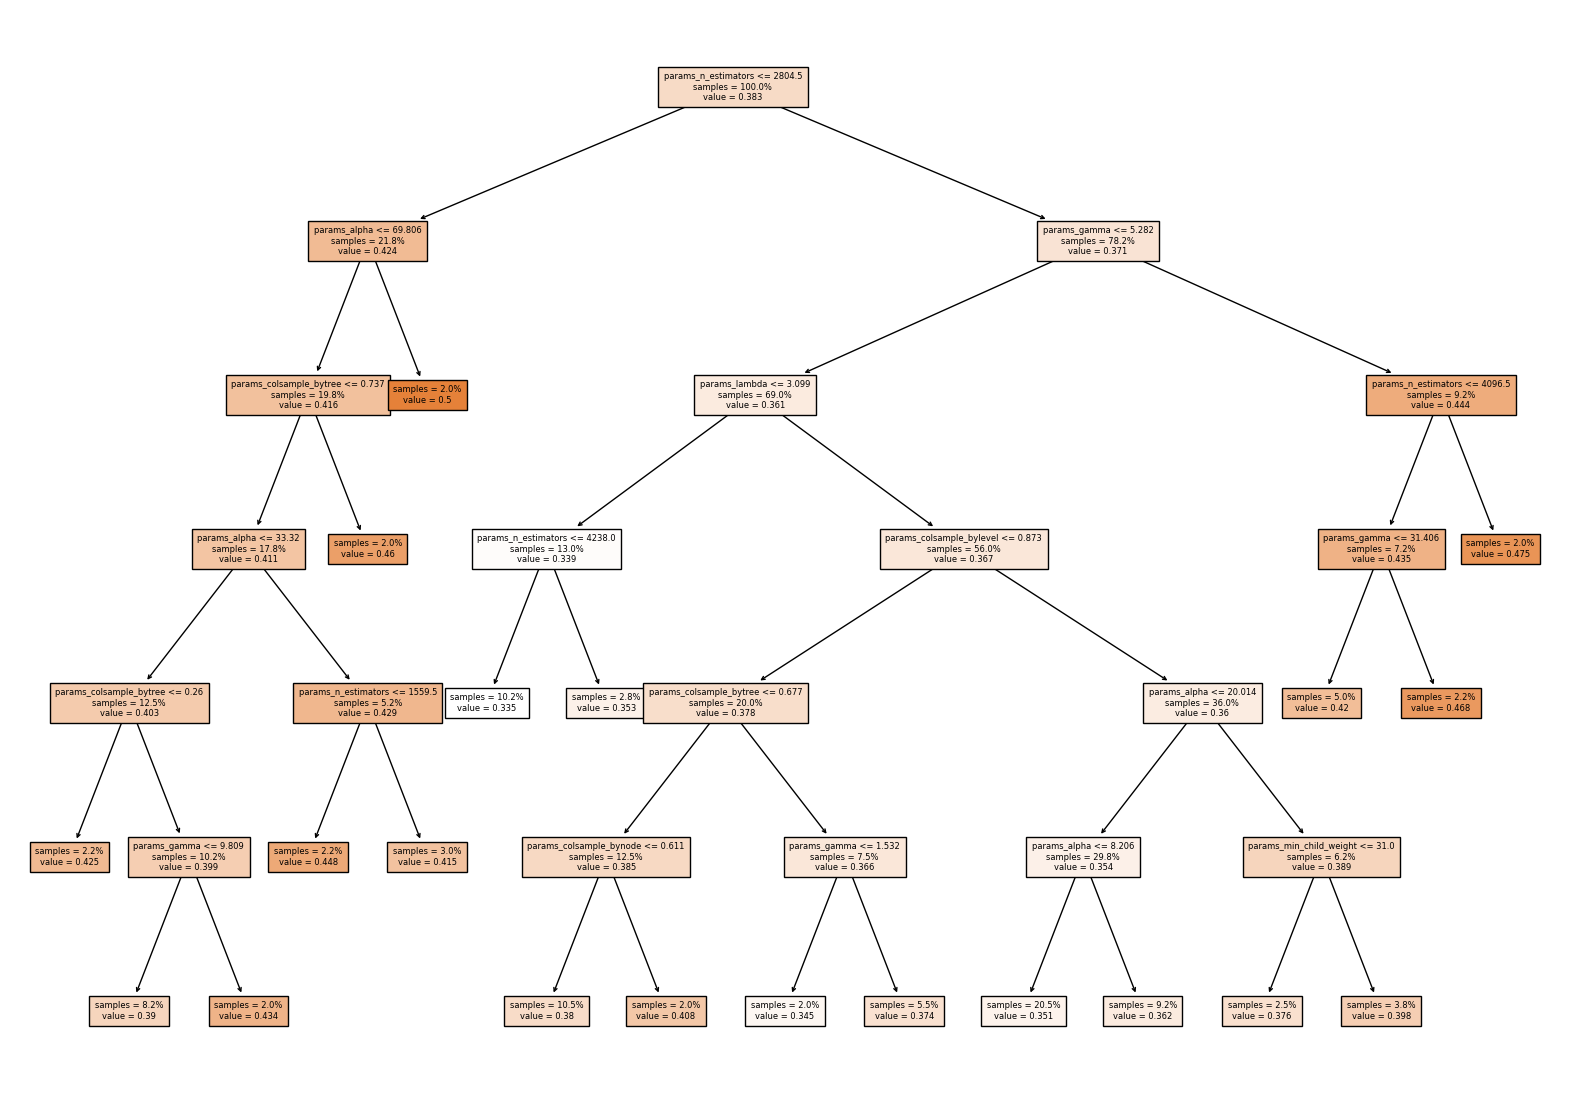

In [ ]:
plt.figure(figsize=(20, 14))

plot_tree(
    model,
    feature_names=X_train.columns,
    filled=True,
    impurity=False,
    proportion=True,
    fontsize=6
)

plt.show()

In [ ]:
feature_names = X_train.columns
tree = model.tree_
feature = tree.feature
threshold = tree.threshold
node_indicator = model.decision_path(instance)
n_node_samples = tree.n_node_samples
value = tree.value
leaf_id = model.apply(instance)

print("Decision path:")
for node_index in node_indicator.indices:
    if node_index == leaf_id:
        total_samples = n_node_samples[0]
        leaf_samples = n_node_samples[node_index]
        percentage_samples = (leaf_samples / total_samples) * 100
        val = value[node_index][0][0]
        print(f'Leaf id: {node_index}')
        print(f"Samples = {percentage_samples:.2f}%")
        print(f"Value = {val:.3f}")
    else:
        feature_name = feature_names[feature[node_index]]
        threshold_value = threshold[node_index]
        feature_value = instance.iloc[0, feature[node_index]]
        if feature_value <= threshold_value: condition = "TRUE"
        else: condition = "FALSE"
        print(f"Node {node_index}: {feature_name} <= {threshold_value}  {condition}")

Decision path:
Node 0: params_n_estimators <= 2804.5  FALSE
Node 2: params_gamma <= 5.282354354858398  TRUE
Node 3: params_lambda <= 3.099188804626465  TRUE
Node 7: params_n_estimators <= 4238.0  TRUE
Leaf id: 37
Samples = 10.25%
Value = 0.335


#### **Shap values - XGBRegressor optimization on the California dataset**
As above, we take 3 models to approximate hyperparameter impact.
* RandomForestRegressor
* XGBoostRegressor
* MLPRegressor

Models are trained on the output from optimization process on California dataset. They are tuned with Optuna as well.

##### RandomForestRegressor

In [ ]:
def objective_xgb_california_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 100)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap,
        n_jobs=14
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_random_forest, n_trials=200, n_jobs=14)

[I 2025-01-11 13:04:04,563] A new study created in memory with name: no-name-fb58045f-ba92-4655-bc6d-eee6952a2d24
[I 2025-01-11 13:04:06,513] Trial 3 finished with value: 0.009101763603727607 and parameters: {'n_estimators': 451, 'max_depth': 32, 'max_features': 0.6776610786655028, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,740] Trial 12 finished with value: 0.012067006021504493 and parameters: {'n_estimators': 82, 'max_depth': 82, 'max_features': 0.8747686874864191, 'min_samples_leaf': 19, 'min_samples_split': 20, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,740] Trial 1 finished with value: 0.0104706449461383 and parameters: {'n_estimators': 253, 'max_depth': 73, 'max_features': 0.5305127939222999, 'min_samples_leaf': 8, 'min_samples_split': 11, 'bootstrap': False}. Best is trial 3 with value: 0.009101763603727607.
[I 2025-01-11 13:04:06,

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.008542178450529271
Params: {'n_estimators': 796, 'max_depth': 62, 'max_features': 0.7814424287826952, 'min_samples_leaf': 1, 'min_samples_split': 2, 'bootstrap': True}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='random_forest_best_params', directory='xgb_california_models')

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='xgb_california_models')

In [ ]:
model = RandomForestRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=62, max_features=0.7814424287826952,
                      n_estimators=796)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

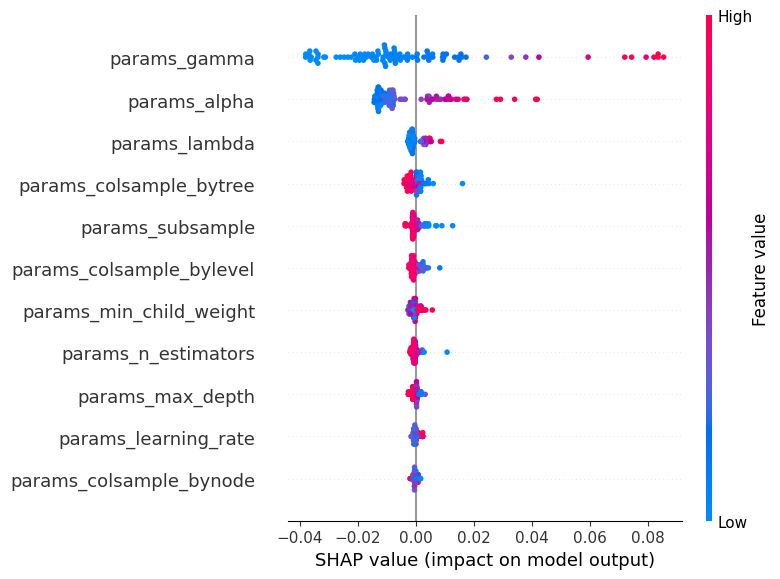

In [ ]:
shap.summary_plot(shap_values, X_test)

Better performance (lower MEA) can be achieved when:
* *alpha* value is low
* *lamda* value is low
* *colsample_bytree* value is high
* *colsample_bylevel* value is high
* *subsample* value value is high
* *n_estimators* value is high
* *max_depth* value is high

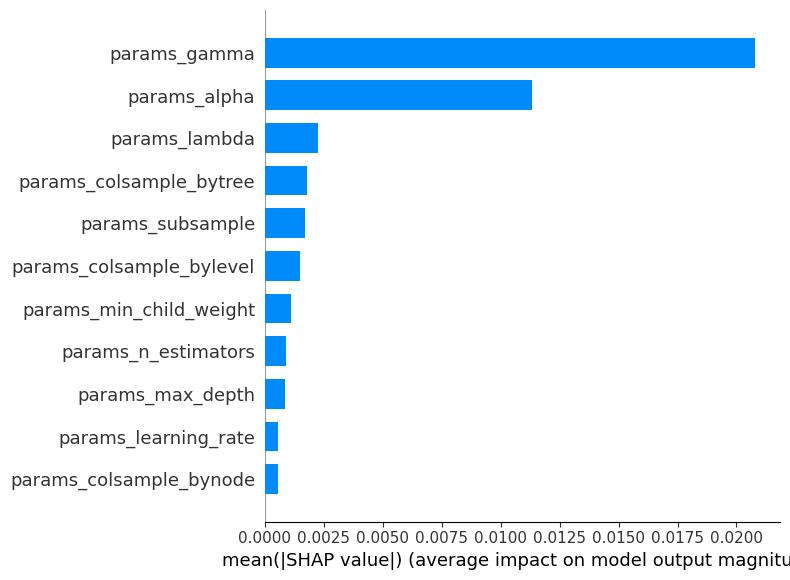

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on the optimization process:
* gamma
* alpha

Least important features:
* colsample_bynode
* learning_rate

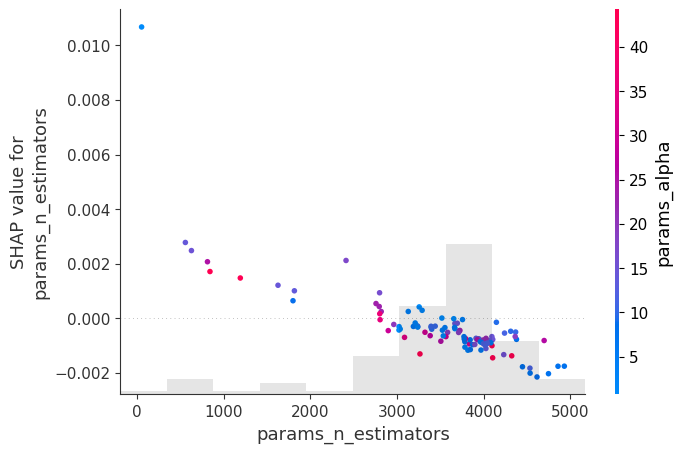

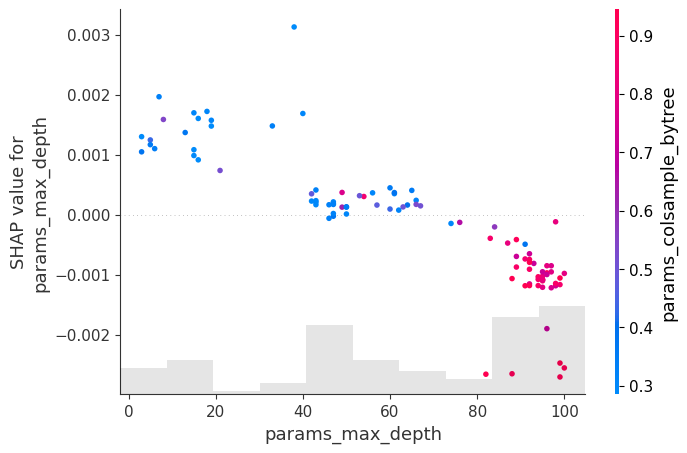

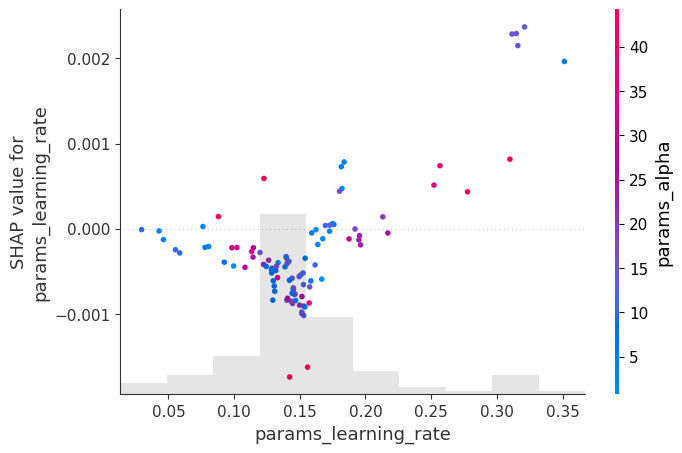

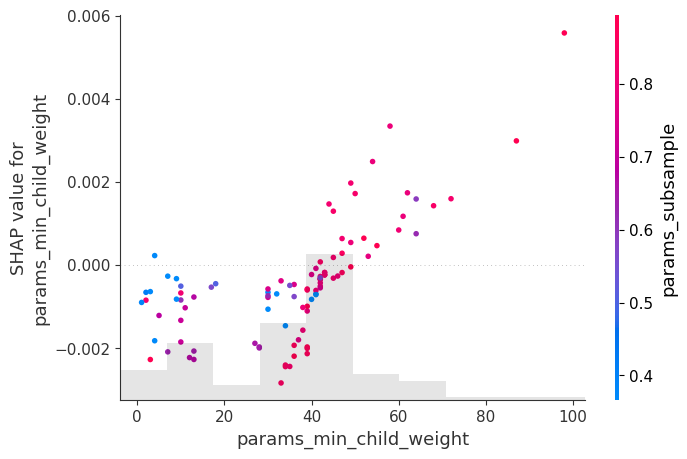

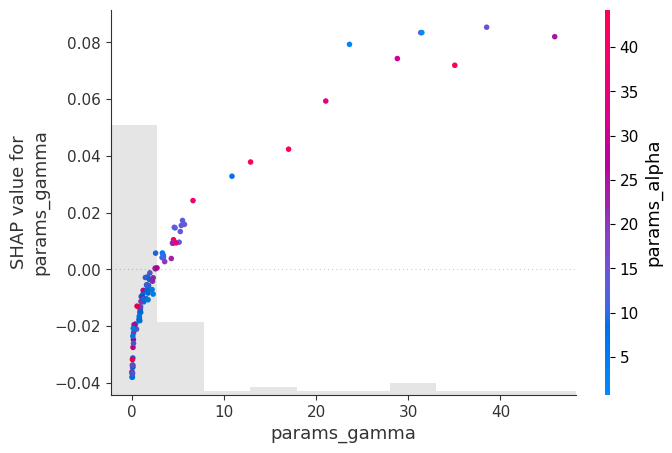

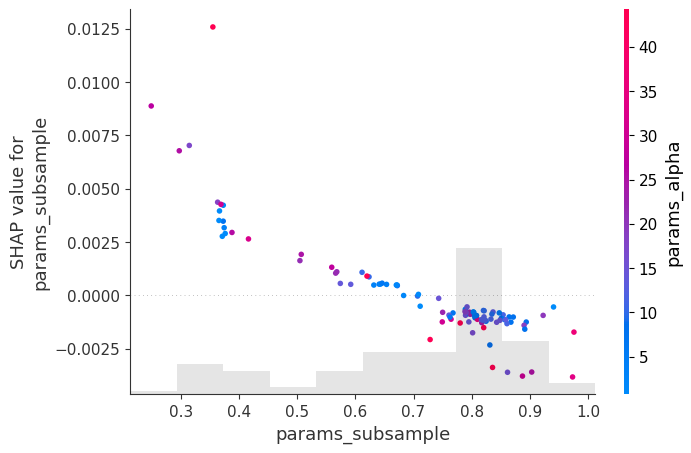

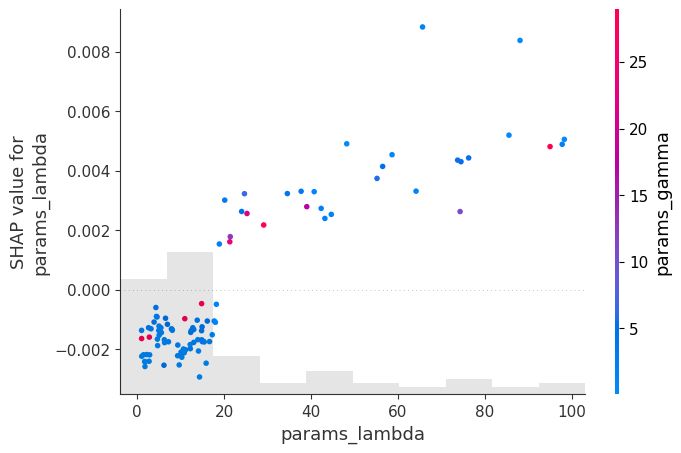

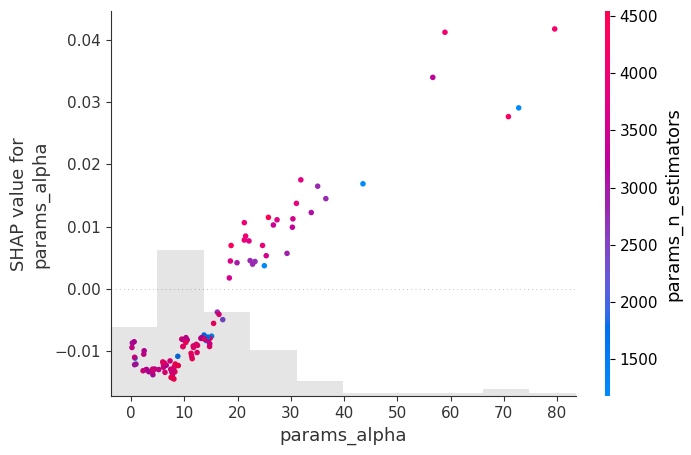

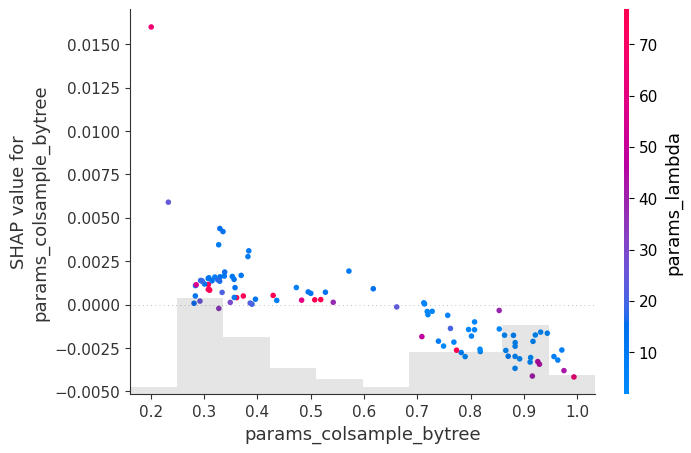

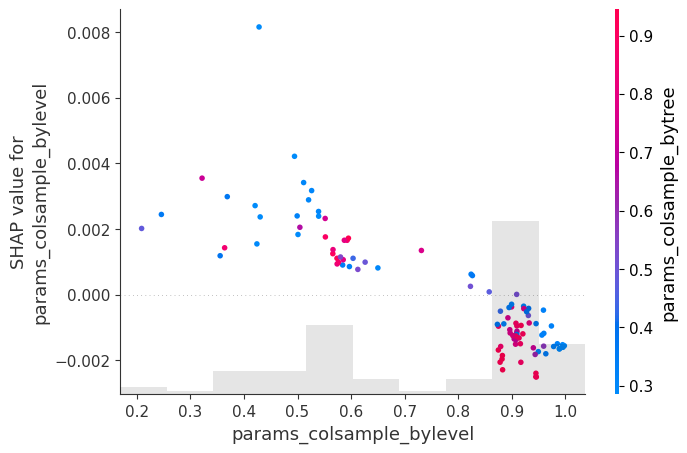

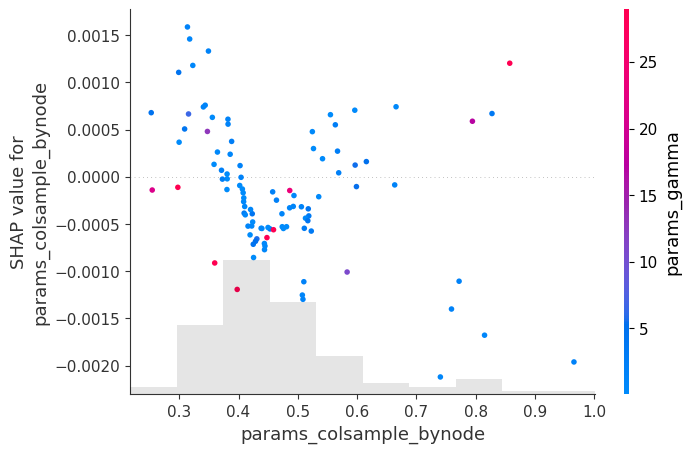

In [ ]:
feature_names = list(X_test.columns)

for i, column in enumerate(X_test.columns):
    shap.plots.scatter(shap_values[:, feature_names.index(column)], color=shap_values)


Analyzing the charts we can see that most instances have negative impact.
Values of hyperparameters Optuna chose more frequently:
* n_estimators: 3000 - 4000
* max_depth: 40 - 60 and 90 - 100
* learning_rate: 0.10-0.15
* min_child_weight: 30 - 50
* gamma: 0 - 5
* subsample: 0.8 - 0.9
* lambda: 0 - 20
* alpha: 0 - 20
* colsample_bytree: 0.3 - 0.4 and 0.8 - 0.9
* colsample_bylevel: 0.9 - 1.0

Hyperparameters with the following values ​​have a positive impact:
* max_depth: > 80
* min_child_weight: < 40
* gamma: < 1
* subsample: > 0.7
* lambda: < 20
* alpha: < 20
* colsample_bytree: > 0.7
* colsample_bylevel: > 0.8

In [ ]:
shap_values_for_best_record = explainer(best_params_instance)

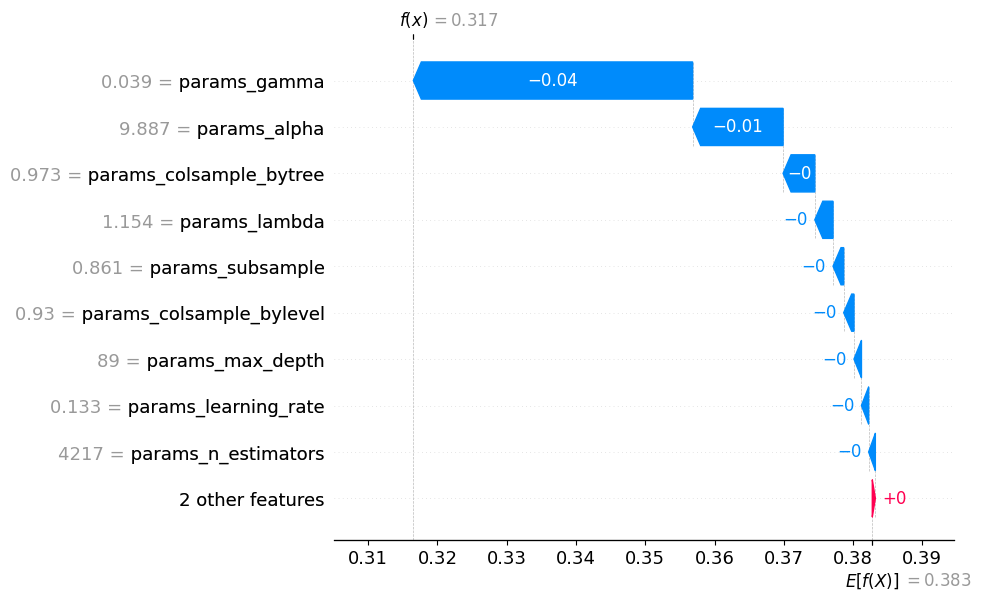

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the lowest MAE score, the greatest negative impact on the result (compared to the average) have:
* gamma
* alpha
* colsample_bytree

The rest of the parameters have a slight influence on the score.

##### XGBoostRegressor

In [ ]:
def objective_xgb_california_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        n_estimators=n_estimators,
        subsample=subsample,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        n_jobs=14
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_xgb, n_trials=200, n_jobs=14)

[I 2025-01-11 13:18:19,809] A new study created in memory with name: no-name-6eeff5cb-2a59-4ed1-ab35-52ed0361734c
[I 2025-01-11 13:18:31,206] Trial 0 finished with value: 0.03356826662944204 and parameters: {'learning_rate': 0.10297004261459092, 'max_depth': 30, 'min_child_weight': 4, 'gamma': 4, 'n_estimators': 679, 'subsample': 0.8200010241089626}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18:45,728] Trial 9 finished with value: 0.03357896169274474 and parameters: {'learning_rate': 0.08859047303720818, 'max_depth': 44, 'min_child_weight': 9, 'gamma': 6, 'n_estimators': 698, 'subsample': 0.7715263139027766}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18:48,735] Trial 13 finished with value: 0.033595585288956786 and parameters: {'learning_rate': 0.11397581536963106, 'max_depth': 92, 'min_child_weight': 10, 'gamma': 4, 'n_estimators': 223, 'subsample': 0.9504549995931492}. Best is trial 0 with value: 0.03356826662944204.
[I 2025-01-11 13:18

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.007030875950353617
Params: {'learning_rate': 0.02312213958585093, 'max_depth': 32, 'min_child_weight': 6, 'gamma': 0, 'n_estimators': 462, 'subsample': 0.6875720033014668}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='xgb_best_params', directory='xgb_california_models')

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='xgb_california_models')

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0231221395858509,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=462, n_jobs=10,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

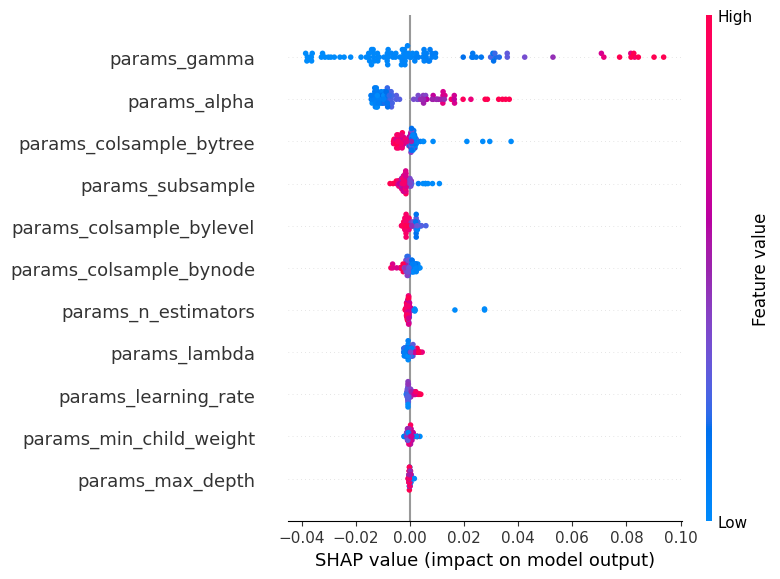

In [ ]:
shap.summary_plot(shap_values, X_test)

Better performance can be achieved when:
* *alpha* has low values
* *colsample_bytree* has high values
* *subsample* has high values
* *colsample_bylevel* - high values
* *n_estimators* - high values
* *lambda* has low values
* *learning_rate* has low values

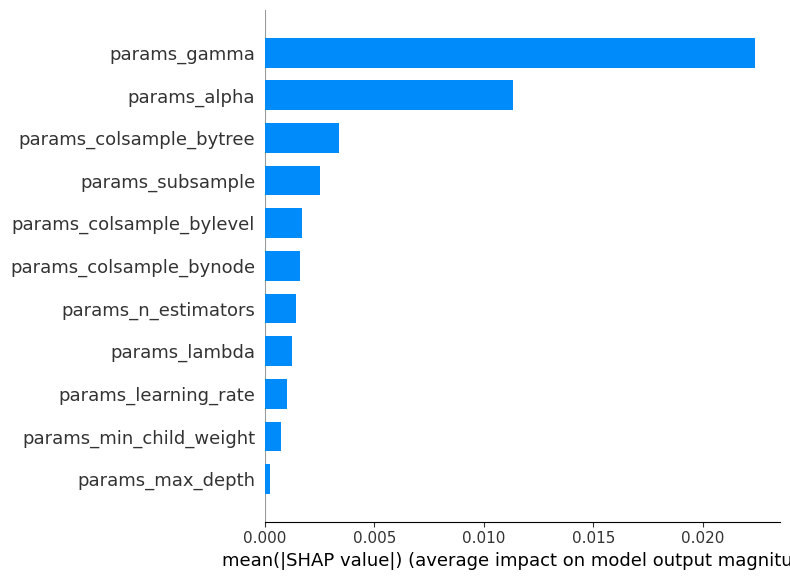

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* gamma
* alpha

Least important features:
* max_depth
* min_child_weight
* learning_rate
* lambda
* n_estimators


In [ ]:
shap_values_for_best_record = explainer(best_params_instance)

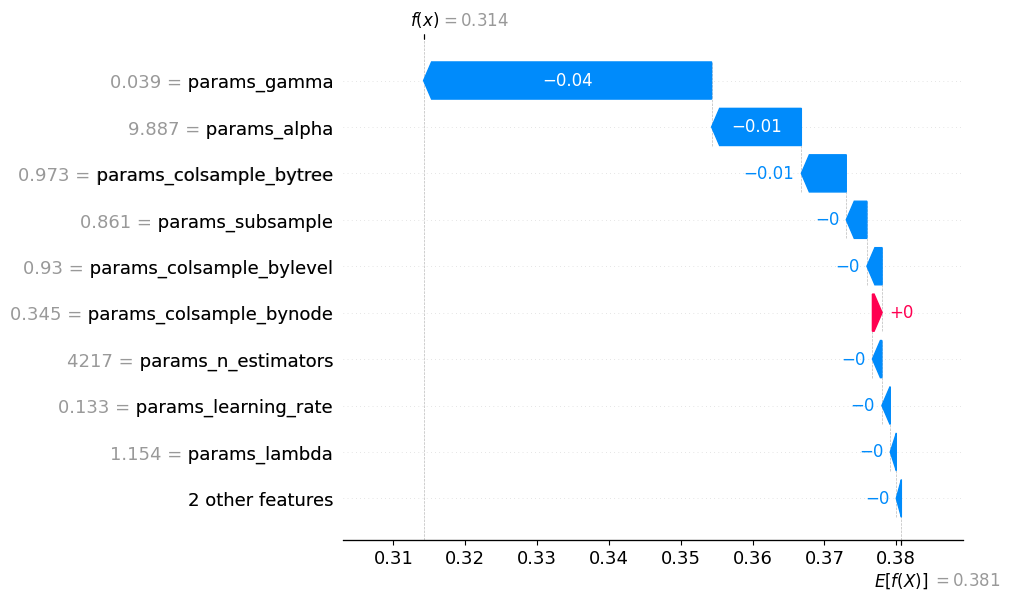

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the lowest MAE score, the greatest negative impact on the result (compared to the average) have:
* gamma
* alpha
* colsample_bytree

The rest of the parameters have a slight influence on the score.

##### MLPRegressor

In [ ]:
def objective_xgb_california_mlp(trial):

    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(25,), (50,), (100,), (50, 25), (100, 50)]
    )
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.001)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        alpha=alpha,
        max_iter=max_iter
    )

    score = -cross_val_score(
        model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error", n_jobs=14
    ).mean()

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb_california_mlp, n_trials=200, n_jobs=14)

[I 2025-01-11 13:38:47,031] A new study created in memory with name: no-name-9e76ef81-0b7c-4387-9de3-6ac0c34350d6
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 25) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (25,) which is of type tuple.
  warnings.warn(message)
C:\Users\Rafal\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.wa

In [ ]:
print(f"Value: {study.best_value}")
print(f"Params: {study.best_params}")

Value: 0.04441064115907192
Params: {'hidden_layer_sizes': (25,), 'solver': 'lbfgs', 'learning_rate_init': 0.0009227468266574, 'batch_size': 16, 'alpha': 0.0012835898782810216, 'max_iter': 1423}


In [ ]:
best_params_df = pd.DataFrame([study.best_params])
save_results(best_params_df, filename='mlp_best_params', directory='xgb_california_models')

In [ ]:
best_params_df = load_results(filename='mlp_best_params', directory='xgb_california_models')

In [ ]:
model = MLPRegressor(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train)

MLPRegressor(alpha=0.001283589878281, batch_size=16, hidden_layer_sizes=(25,),
             learning_rate_init=0.0009227468266574, max_iter=1423,
             solver='lbfgs')

In [ ]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

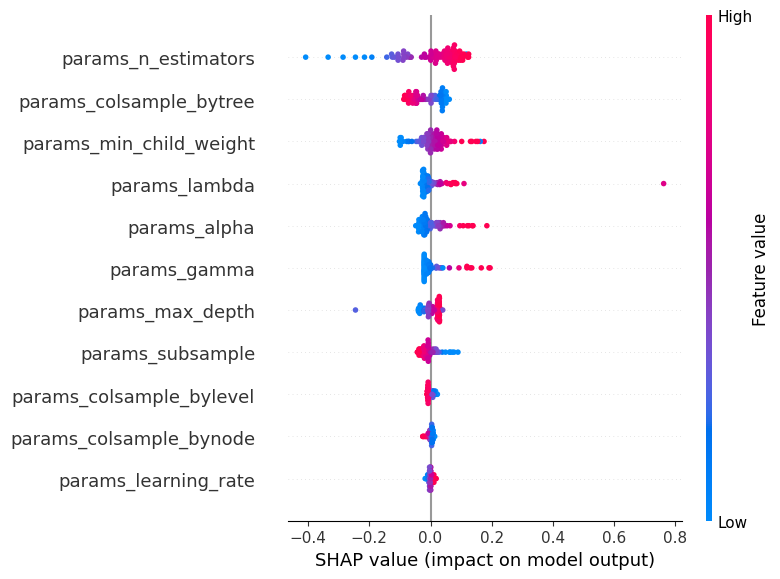

In [ ]:
shap.summary_plot(shap_values, X_test)

Analyzing the graph we can conclude that the lower the values of hyperparameters: *n_estimators*, *min_child_weight*,  *lambda*, *alpha*, *gamma*, *max_depth*, the more negative impact they have on the model output (the MAE is lower).

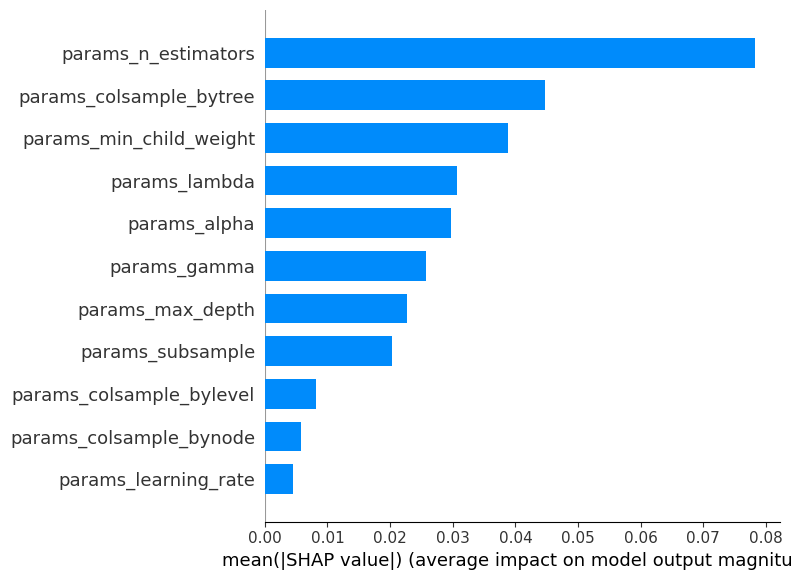

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Hyperparameters with the greatest average impact on optimization process:
* n_estimators
* colsample_bytree
* min_child_weight

Least important features:
* learning_rate
* colsample_bynode

In [ ]:
shap_values_for_best_record = explainer(best_params_instance)

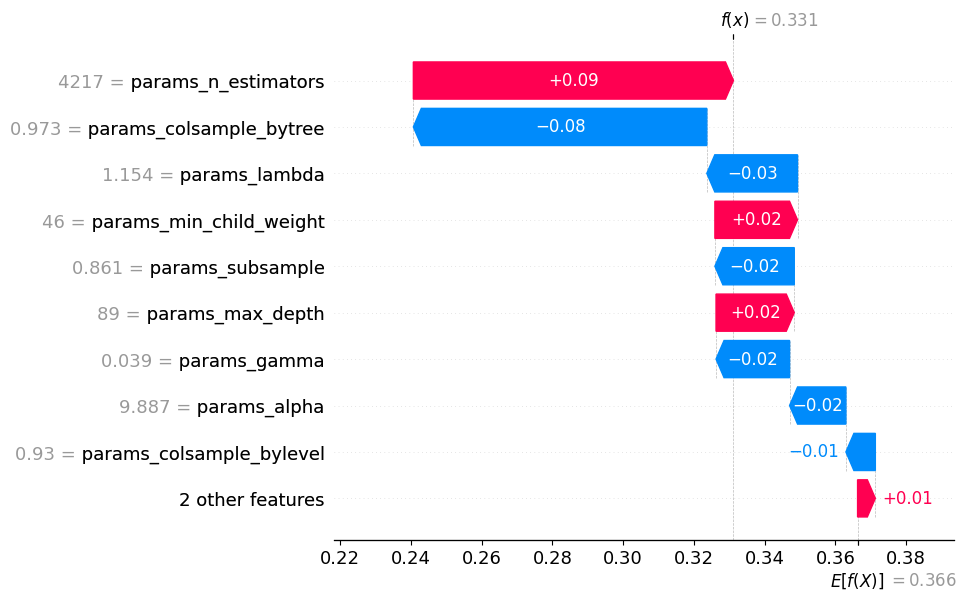

In [ ]:
shap.plots.waterfall(shap_values_for_best_record[0])

Considering the instance for which we obtained the lowest MAE score, negative impact on the result (compared to the average) have:
* colsample_bytree
* lambda
* subsample
* gamma
* alpha
* colsample_bylevel.

And the positive impact have:
* n_estimators
* min_child_weight
* max_depth

##### **Summary**

From RandomForest and XGBoost resressors we received similiar results again. Top 2 most important parameters are the same: *gamma*, *alpha* but there are differences in the least important ones. When comparing the feature importances obtained in the optimization process, the regressors did not focus on the hyperparameter *subsample* that, according to Optuna, was the second crucial one.
The MLPRegressor again gave us different results where the *n_estimators* is the key parameter.
According to all models, *learning_rate* is one of the least important features.

#### **LORE explanations - XGBRegressor optimization on California dataset**

In [111]:
y_train_intervals = pd.cut(y_train, 10)
y_train_categorical = y_train_intervals.map(str)

In [112]:
le = LabelEncoder()
le.fit(y_train_categorical)
y_train_categorical_encoded = le.transform(y_train_categorical)

In [113]:
intervals_labels = pd.DataFrame(columns=le.classes_, data=[np.arange(len(le.classes_))], index=[0])
intervals_labels

(0.312, 0.342]  (0.342, 0.373]  (0.373, 0.403]  (0.403, 0.433]  \
0               0               1               2               3   

   (0.433, 0.463]  (0.463, 0.493]  (0.493, 0.523]  (0.553, 0.583]  \
0               4               5               6               7   

   (0.583, 0.613]  
0               8

##### RandomForestClassifier

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='xgb_california_models')

In [ ]:
model = RandomForestClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train_categorical_encoded)

RandomForestClassifier(max_depth=62, max_features=0.7814424287826952,
                       n_estimators=796)

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_instance.iloc[0].values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

##### XGBClassifier

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='xgb_california_models')

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train_categorical_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0231221395858509,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=462, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_instance.iloc[0].values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

##### MLPClassifier

In [ ]:
best_params_df = load_results(filename='mlp_best_params', directory='xgb_california_models')

In [ ]:
model = MLPClassifier(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train_categorical_encoded)

MLPClassifier(alpha=0.001283589878281, batch_size=16, hidden_layer_sizes=(25,),
              learning_rate_init=0.0009227468266574, max_iter=1423,
              solver='lbfgs')

In [ ]:
model_wrapper = sklearn_classifier_wrapper(model)

In [ ]:
lore_explainer = LoreTabularExplainer(model_wrapper)
config = {'neigh_type':'geneticp', 'size':100, 'ocr':0.1, 'ngen':50}
lore_explainer.fit(X_train.assign(label=y_train_categorical_encoded), 'label', config)
exp = lore_explainer.explain(best_params_instance.iloc[0].values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

#### **LUX explanations - XGBRegressor optimization on California dataset**

##### RandomForestClassifier

In [ ]:
best_params_df = load_results(filename='random_forest_best_params', directory='xgb_california_models')

In [ ]:
model = RandomForestClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_samples_split=int(best_params_df['min_samples_split'].iloc[0]),
    min_samples_leaf=int(best_params_df['min_samples_leaf'].iloc[0]),
    bootstrap=bool(best_params_df['bootstrap'].iloc[0]),
    max_features=best_params_df['max_features'].iloc[0]
)

model.fit(X_train, y_train_categorical_encoded)

RandomForestClassifier(max_depth=62, max_features=0.7814424287826952,
                       n_estimators=796)

In [ ]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.1,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_instance.iloc[0].values.reshape(1, -1),inverse_sampling=True,
        oversampling=False, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True)

LUX(max_depth=3, min_samples=50, node_size_limit=4,
    oversampling_strategy='smote',
    predict_proba=<bound method ForestClassifier.predict_proba of RandomForestClassifier(max_depth=62, max_features=0.7814424287826952,
                       n_estimators=796)>)

In [ ]:
lux.justify(best_params_instance.iloc[0].values.reshape(1,-1))

['IF params_gamma <1.0755740702152252 AND params_alpha <19.96714687347412 THEN class = 0 # 0.9047619047619048\n']

In [ ]:
cf =lux.counterfactual(best_params_instance.iloc[0].values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

{'params_gamma': ['<1.8264356851577759', '>=1.0755740702152252'],
 'params_alpha': ['<19.96714687347412']}

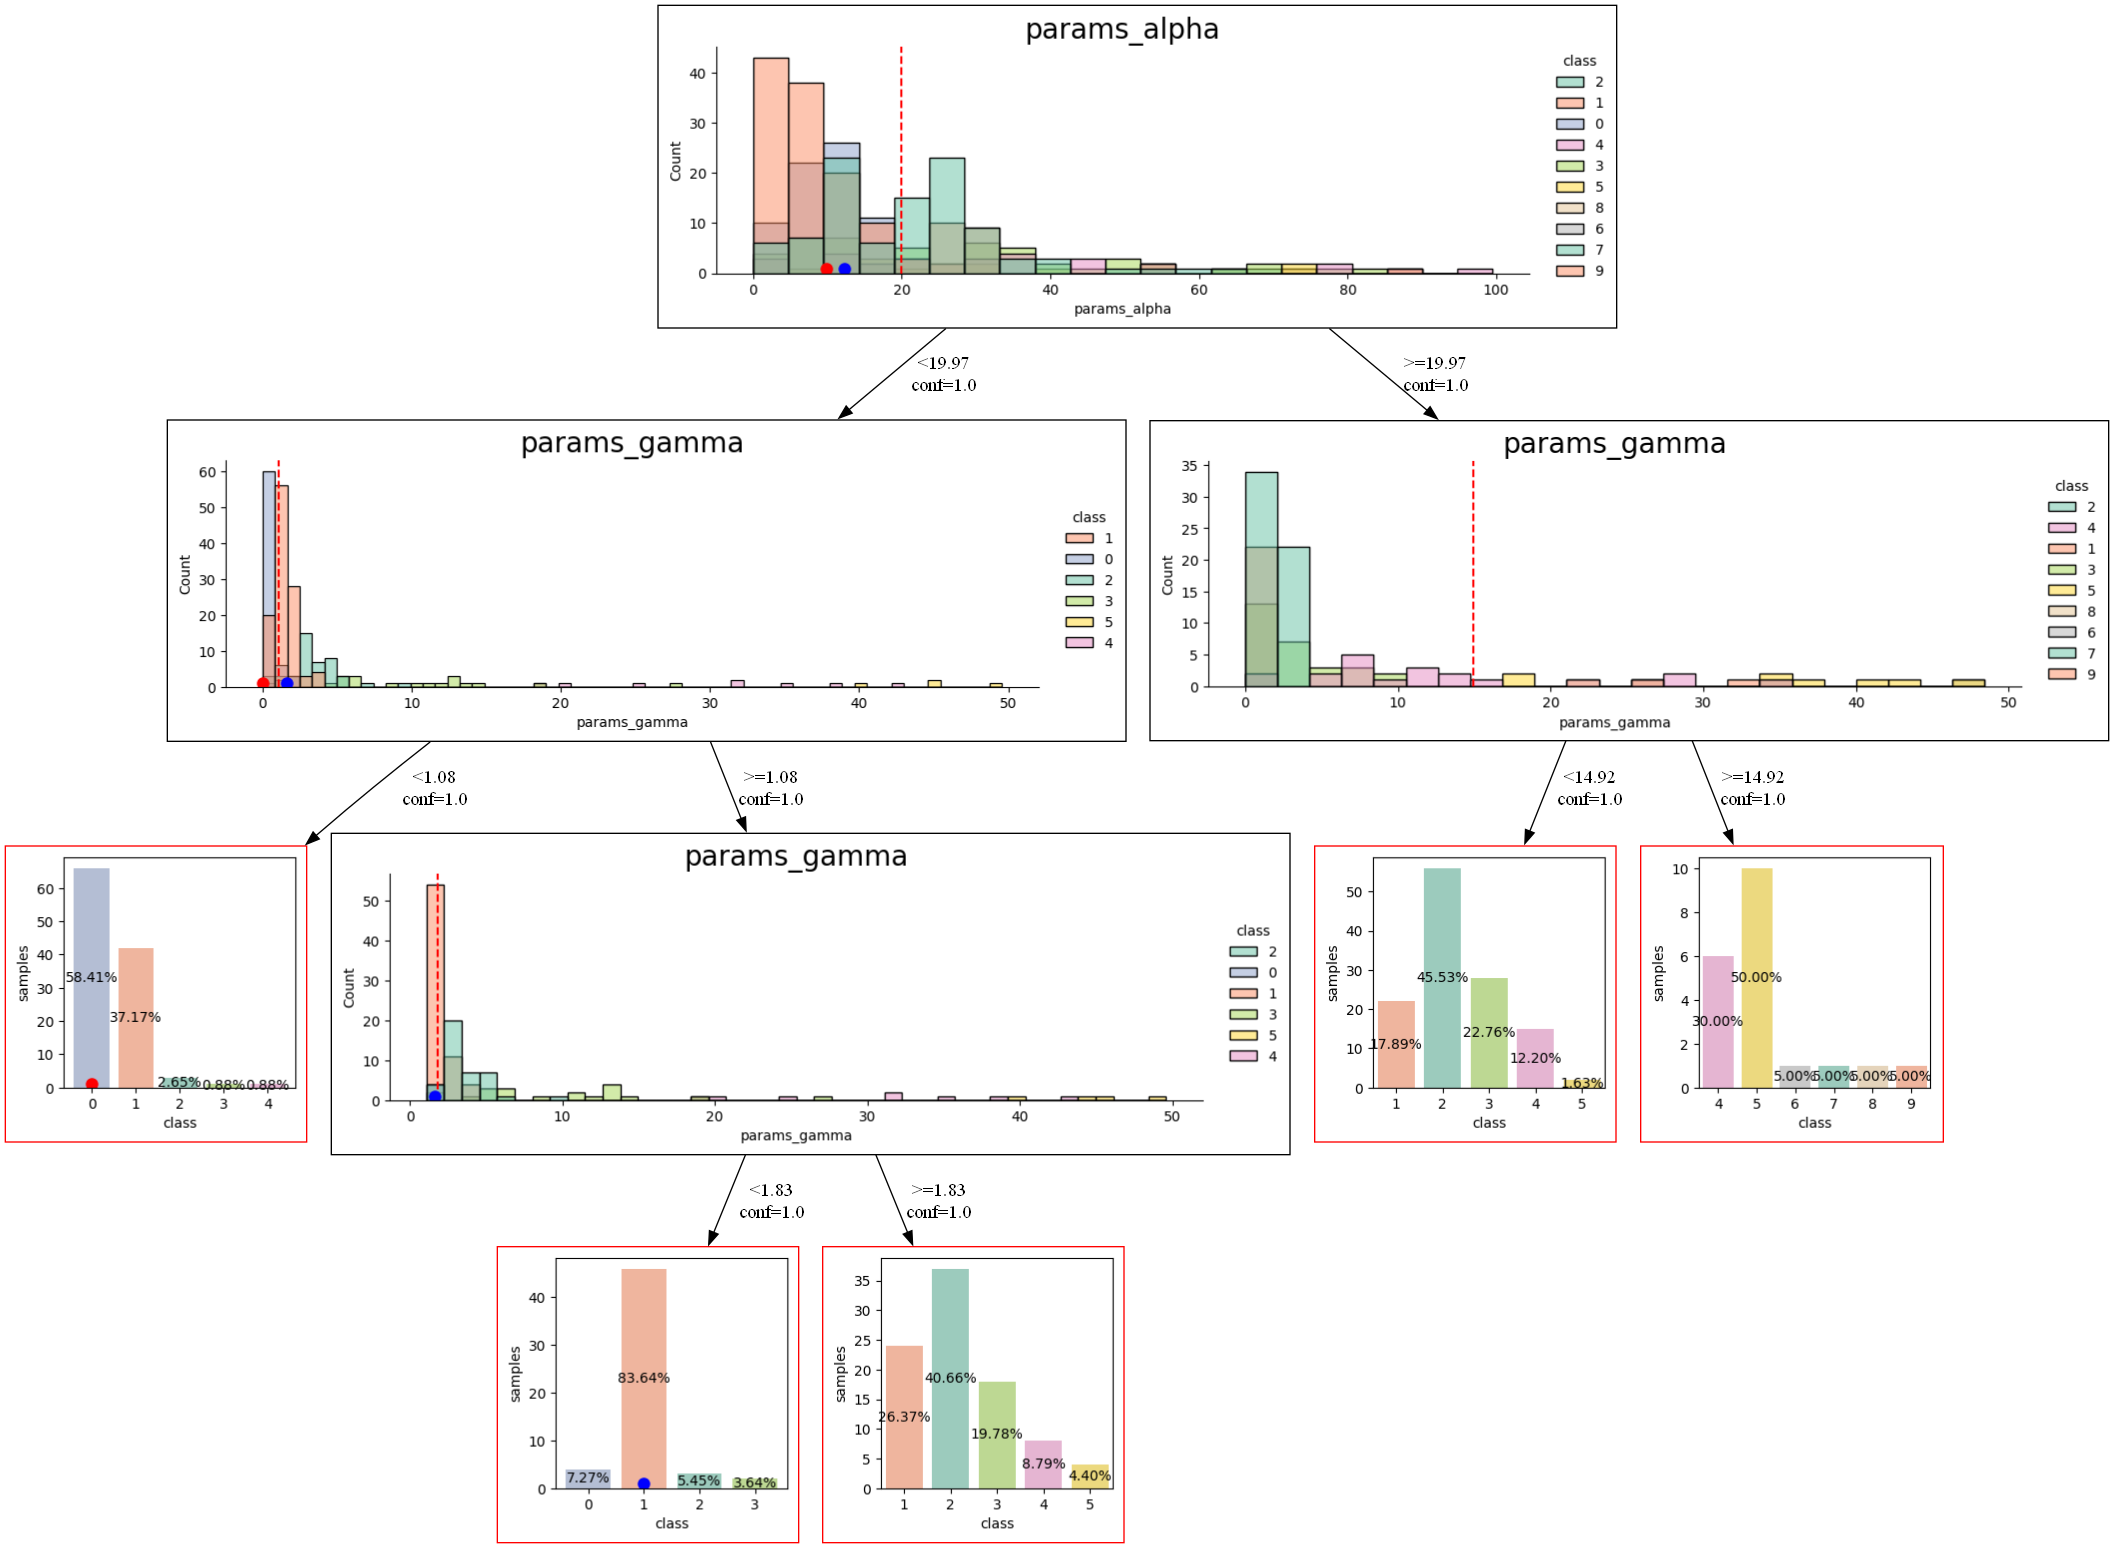

In [ ]:
i2edf = pd.DataFrame(best_params_instance.iloc[0].values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_4.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_4.dot')
!dot -Tpng ./tree-cf-visual_4.dot > tree_4.png
Image('tree_4.png')

##### XGBClassifier
Unfortunately, we were unable to obtain any explanation.

In [ ]:
best_params_df = load_results(filename='xgb_best_params', directory='xgb_california_models')

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=int(best_params_df['n_estimators'].iloc[0]),
    max_depth=int(best_params_df['max_depth'].iloc[0]),
    min_child_weight=int(best_params_df['min_child_weight'].iloc[0]),
    gamma=float(best_params_df['gamma'].iloc[0]),
    subsample=float(best_params_df['subsample'].iloc[0]),
    learning_rate=float(best_params_df['learning_rate'].iloc[0]),
    n_jobs=10
)

model.fit(X_train, y_train_categorical_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0231221395858509,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=462, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.2,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_instance.iloc[0].values.reshape(1, -1),inverse_sampling=True,
        oversampling=False, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True)

In [ ]:
lux.justify(best_params_instance.iloc[0].values.reshape(1,-1))

In [ ]:
cf =lux.counterfactual(best_params_instance.iloc[0].values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

In [ ]:
i2edf = pd.DataFrame(best_params_instance.iloc[0].values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_5.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_5.dot')
!dot -Tpng ./tree-cf-visual.dot > tree.png
Image('tree_5.png')

##### MLPClassifier
Unfortunately, we were unable to obtain any explanation.

In [114]:
best_params_df = load_results(filename='mlp_best_params', directory='xgb_california_models')

In [115]:
model = MLPClassifier(
    hidden_layer_sizes=eval(best_params_df['hidden_layer_sizes'].iloc[0]),
    solver=best_params_df['solver'].iloc[0],
    learning_rate_init=float(best_params_df['learning_rate_init'].iloc[0]),
    batch_size=int(best_params_df['batch_size'].iloc[0]),
    alpha=float(best_params_df['alpha'].iloc[0]),
    max_iter=int(best_params_df['max_iter'].iloc[0])
)

model.fit(X_train, y_train_categorical_encoded)

MLPClassifier(alpha=0.001283589878281, batch_size=16, hidden_layer_sizes=(25,),
              learning_rate_init=0.0009227468266574, max_iter=1423,
              solver='lbfgs')

In [180]:
lux = LUX(predict_proba = model.predict_proba,
          #classifier=model, #Uncomment to use SHAP=based sampling. This will take long time time as the SHAP values will have to be recalcualted for every split
          neighborhood_size=0.15,max_depth=20,  node_size_limit = 50, grow_confidence_threshold = 0.6)
lux.fit(X_train, y_train_categorical_encoded, instance_to_explain=best_params_instance.iloc[0].values.reshape(1, -1),inverse_sampling=True, use_parity=False,
        oversampling=True, #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=True)

LUX(grow_confidence_threshold=0.6, max_depth=20, neighborhood_size=0.15,
    node_size_limit=50, oversampling_strategy='smote',
    predict_proba=<bound method MLPClassifier.predict_proba of MLPClassifier(alpha=0.001283589878281, batch_size=16, hidden_layer_sizes=(25,),
              learning_rate_init=0.0009227468266574, max_iter=1423,
              solver='lbfgs')>)

In [181]:
lux.justify(best_params_instance.iloc[0].values.reshape(1,-1))

['IF  THEN class = 1 # 1.0\n']

In [ ]:
cf =lux.counterfactual(best_params_instance.iloc[0].values.reshape(1,-1), background=X_train, counterfactual_representative='nearest', topn=1)[0]
cf['rule']

In [ ]:
i2edf = pd.DataFrame(best_params_instance.iloc[0].values.reshape(1,-1), columns = X_train.columns)
cf_nearest = cf['counterfactual'].to_frame().T
cf_nearest['class']= model.predict(cf_nearest)
i2edf['class']= model.predict(i2edf)

X_train_bg = X_train.copy()
X_train_bg['class']=y_train_categorical_encoded
lux.uid3.tree.save_dot('tree-cf-visual_6.dot',fmt='.2f',visual=True, background_data=X_train_bg, instance2explain = i2edf, counterfactual=cf_nearest)
gvz=graphviz.Source.from_file('tree-cf-visual_6.dot')
!dot -Tpng ./tree-cf-visual.dot > tree.png
Image('tree_6.png')